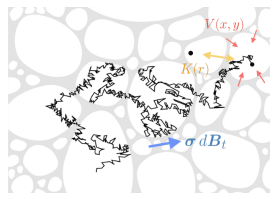

In [ ]:
%pip install symengine

!wget -q https://raw.githubusercontent.com/SethMinor/PyWSINDy-for-PDEs/main/wsindy.py
!wget -q https://raw.githubusercontent.com/SethMinor/PyWSINDy-for-PDEs/main/helper_fcns.py

In [ ]:
# Core
import torch
import scipy
import numpy as np
import matplotlib
import itertools
import symengine as sp
import pandas as pd

# Special
import torch.linalg as la
from scipy.signal import convolve
from scipy.special import factorial
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display,Math

# Weak SINDy
from wsindy import *
from helper_fcns import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/WSINDy

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/WSINDy


In [ ]:
# Plot settings
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100

matplotlib.rc('xtick', labelsize=10, direction='out')
matplotlib.rc('ytick', labelsize=10, direction='out')

# Import data

In [ ]:
# Empirical dataset
file_path = '/content/drive/My Drive/WSINDy/Caterpillar/caterpillars.csv'
cats = pd.read_csv(file_path)

# Exclude the trial run (June 15)
cats = cats[cats['Run'] != 'Jun-15']
print(f"Data-frame shape: {cats.shape}")

# Time
t = cats['Time'].unique()
tau = np.linspace(0, 7, 8)
print(f'Times, t = {t}')
print(f'Tau = {tau}')

del file_path

Data-frame shape: (964, 12)
Times, t = [ 0  1  2  4  8 16 24 48]
Tau = [0. 1. 2. 3. 4. 5. 6. 7.]


In [ ]:
# # OBSERVED TIME
# # Time scaling (du/dt = scales * du/dtau)
# alpha = 2/np.log(3)
# #tau_prime = alpha/(t+1) # τ'(t_k)
# #tau_prime = 1/np.append(np.diff(t), np.diff(t)[-1]) # Δτ_k/Δt_k

# # Approximate but good
# t_smooth = np.linspace(t.min(), t.max(), 100)

# plt.figure(figsize=(6, 3))
# plt.plot(t_smooth, alpha*np.log(t_smooth+1), label=r"$\tau(t)$")
# #plt.plot(t_smooth, t_smooth**0.5, label=r"$\sqrt{t}$")
# plt.plot(t, tau, 'o')
# plt.plot(t_smooth, alpha/(t_smooth+1), label=r"$\tau'(t)$")
# #plt.plot(t, tau_prime, '.--', label=r"$\Delta\tau_k/\Delta{t}_k$")
# plt.xlabel(r'$t$')
# plt.legend()
# plt.grid(True)
# plt.show()

# del t_smooth

Experiments:
- $\Omega_1$ (`Plot = 1`): Stonewall, not infected
- $\Omega_2$ (`Plot = 2`): Gasoy, not infected
- $\Omega_3$ (`Plot = 3`): Stonewall, infected
- $\Omega_4$ (`Plot = 4`): Gasoy, infected

In [ ]:
# Which experiments?
run = ['Mar-16', 'Apr-16'] # 'Mar-16' and/or 'Apr-16'
cats = cats[cats['Run'].isin(run)]

# Grouped by common plant type
cats_S = cats[(cats['Run'].isin(run)) & ((cats['Plot'] == 1) | (cats['Plot'] == 3))]
cats_G = cats[(cats['Run'].isin(run)) & ((cats['Plot'] == 2) | (cats['Plot'] == 4))]

# Grouped by common infection statu
cats_N = cats[(cats['Run'].isin(run)) & ((cats['Plot'] == 1) | (cats['Plot'] == 2))]
cats_I = cats[(cats['Run'].isin(run)) & ((cats['Plot'] == 3) | (cats['Plot'] == 4))]

# Separate control populations
cats1 = cats[(cats['Run'].isin(run)) & (cats['Plot'] == 1)]
cats2 = cats[(cats['Run'].isin(run)) & (cats['Plot'] == 2)]
cats3 = cats[(cats['Run'].isin(run)) & (cats['Plot'] == 3)]
cats4 = cats[(cats['Run'].isin(run)) & (cats['Plot'] == 4)]

del run

## Histograms

Histogram (empirical measure): $u(\boldsymbol{x},t) = \frac{1}{N_t |\mathcal{B}|}\sum_{k}\sum_{i} \mathbf{1}_{\mathcal{B}_k}(\boldsymbol{x}) \cdot \mathbf{1}_{\mathcal{B}_k}\!\!\left( \mathbf{x}_t^{i} \right)$

In [ ]:
# Bins in (x,y)
#(Nx, Ny) = (40, 40)
#(Nx, Ny) = (50, 50)
(Nx, Ny) = (80, 80)

# Create a 2D histogram for each time
hists = []
hists_SG = [[] for _ in range(2)]
hists_NI = [[] for _ in range(2)]
hists_n = [[] for _ in range(4)]

for tn in t:
  df = cats[cats['Time'] == tn]
  hist,_ = np.histogramdd(
    df[['X', 'Y']].to_numpy(),
    bins = (Nx, Ny),
    range = ((0,175),(0,175)),
    #density = False)
    density = True)
  hists.append(hist)

  # Different plant types
  for n,cats_n in enumerate([cats_S, cats_G]):
    df = cats_n[cats_n['Time'] == tn]
    hist,_ = np.histogramdd(
      df[['X', 'Y']].to_numpy(),
      bins = (Nx, Ny),
      range = ((0, 175), (0, 175)),
      #density = False)
      density = True)
    hists_SG[n].append(hist)

  # Infection status
  for n,cats_n in enumerate([cats_N, cats_I]):
    df = cats_n[cats_n['Time'] == tn]
    hist,_ = np.histogramdd(
      df[['X', 'Y']].to_numpy(),
      bins = (Nx, Ny),
      range = ((0, 175), (0, 175)),
      #density = False)
      density = True)
    hists_NI[n].append(hist)

  # Separate control populations
  for n,cats_n in enumerate([cats1, cats2, cats3, cats4]):
    df = cats_n[cats_n['Time'] == tn]
    hist,_ = np.histogramdd(
      df[['X', 'Y']].to_numpy(),
      bins = (Nx, Ny),
      range = ((0, 175), (0, 175)),
      #density = False)
      density = True)
    hists_n[n].append(hist)

# Convert to torch tensor
U_h = torch.tensor(np.array(hists)).permute(1,2,0)
[UN_h, UI_h] = [torch.tensor(np.array(hists_NI[n])).permute(1,2,0) for n in range(2)]
[US_h, UG_h] = [torch.tensor(np.array(hists_SG[n])).permute(1,2,0) for n in range(2)]
[U1_h, U2_h, U3_h, U4_h] = [torch.tensor(np.array(hists_n[n])).permute(1,2,0) for n in range(4)]
print("Shape of U_h:", U_h.shape)

# Space and time
x = torch.linspace(0, 175, Nx, dtype=torch.float64)
y = torch.linspace(0, 175, Ny, dtype=torch.float64)
X,Y = np.meshgrid(x, y, indexing='ij')
[dx, dy] = [x.diff()[0], y.diff()[0]]
dtau = np.diff(tau)[0]

del tn, df, hist, _, hists, hists_SG, hists_NI, hists_n, n, cats_n

Shape of U_h: torch.Size([80, 80, 8])


1.0254766864284568


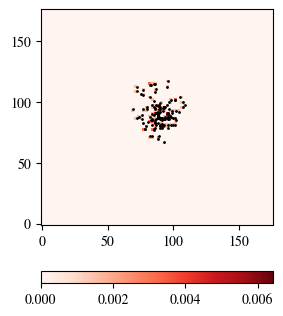

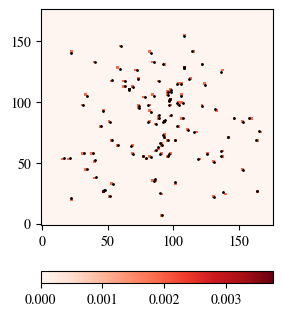

In [ ]:
# Check normalization
print((dx*dy*U_h[:,:,0]).sum().item())

plt.figure(figsize=(3,4))
plt.pcolormesh(X, Y, U_h[:,:,0], cmap='Reds')
plt.colorbar(orientation='horizontal')
plt.scatter(cats[cats['Time'] == 0]['X'], cats[cats['Time'] == 0]['Y'], s=1, color='k')
plt.show()

plt.figure(figsize=(3,4))
plt.pcolormesh(X, Y, U_h[:,:,-1], cmap='Reds')
plt.colorbar(orientation='horizontal')
plt.scatter(cats[cats['Time'] == 48]['X'], cats[cats['Time'] == 48]['Y'], s=1, color='k')
plt.show()

Radial histogram: $u = u(r,t)$

In [ ]:
# # Radial bins in r
# Nr = 26
# #Nr = int(np.sqrt(Nx**2 + Ny**2))

# # Create a 1D histogram for each time
# hists = []
# hists_n = [[] for _ in range(4)]

# for tn in t:
#   df = cats[cats['Time'] == tn]
#   hist,_ = np.histogramdd(
#     df[['horizontal']].to_numpy(),
#     bins = Nr,
#     #range = ((0,125),),
#     range = ((0,90),),
#     #density = False)
#     density = True)
#   hists.append(hist)

#   for n,cats_n in enumerate([cats1, cats2, cats3, cats4]):
#     df = cats_n[cats_n['Time'] == tn]
#     hist,_ = np.histogramdd(
#       df[['horizontal']].to_numpy(),
#       bins = Nr,
#       #range = ((0, 125),),
#       range = ((0, 90),),
#       #density = False)
#       density = True)
#     hists_n[n].append(hist)

# # Convert to torch tensor
# Ur_h = torch.tensor(np.array(hists)).permute(1,0)
# [Ur1_h, Ur2_h, Ur3_h, Ur4_h] = [torch.tensor(np.array(hists_n[n])).permute(1,0) for n in range(4)]
# print("Shape of Ur_h:", Ur_h.shape)

# # Space
# #r = np.linspace(0, 125, Nr)
# r = np.linspace(0, 90, Nr)
# dr = np.diff(r)[0]

# del tn, df, hist, _, hists, hists_n, n, cats_n

## KDE for $(x,y)$

[Density estimate](https://en.wikipedia.org/wiki/Multivariate_kernel_density_estimation): $u(\boldsymbol{x},t) = \frac{1}{N_t h\sigma}\frac{1}{\sqrt{2\pi}}\sum_{i=1}^{N_t} \exp\left(-\frac{(\boldsymbol{x}-\mathbf{x}_t^i)^2}{2h^2\sigma^2} \right)$

In [ ]:
from scipy.stats import gaussian_kde

def Gaussian_KDE(X, Y, particles):
  G = np.zeros_like(X)
  kernel = gaussian_kde(particles)
  positions = np.vstack([X.ravel(), Y.ravel()])
  G = kernel(positions).reshape(X.shape)
  return G

In [ ]:
# GAUSSIAN KDE
# Bins in (x,y)
#(Nx, Ny) = (50, 50)
(Nx, Ny) = (80, 80)

# KDE evaluation at each time
kdes = []
kdes_SG = [[] for _ in range(2)]
kdes_NI = [[] for _ in range(2)]
kdes_n = [[] for _ in range(4)]

for tn in t:
  df = cats[cats['Time'] == tn]
  particles = np.vstack([df['X'], df['Y']])
  G = Gaussian_KDE(X, Y, particles)
  kdes.append(G)

  # Plant type
  for n,cats_n in enumerate([cats_S, cats_G]):
    df = cats_n[cats_n['Time'] == tn]
    particles = np.vstack([df['X'], df['Y']])
    G = Gaussian_KDE(X, Y, particles)
    kdes_SG[n].append(G)

  # Infection status
  for n,cats_n in enumerate([cats_N, cats_I]):
    df = cats_n[cats_n['Time'] == tn]
    particles = np.vstack([df['X'], df['Y']])
    G = Gaussian_KDE(X, Y, particles)
    kdes_NI[n].append(G)

  # Separate control populations
  for n,cats_n in enumerate([cats1, cats2, cats3, cats4]):
    df = cats_n[cats_n['Time'] == tn]
    particles = np.vstack([df['X'], df['Y']])
    G = Gaussian_KDE(X, Y, particles)
    kdes_n[n].append(G)

# Convert to torch tensor
U = torch.tensor(np.array(kdes)).permute(1,2,0)
[US, UG] = [torch.tensor(np.array(kdes_SG[n])).permute(1,2,0) for n in range(2)]
[UN, UI] = [torch.tensor(np.array(kdes_NI[n])).permute(1,2,0) for n in range(2)]
[U1, U2, U3, U4] = [torch.tensor(np.array(kdes_n[n])).permute(1,2,0) for n in range(4)]
print(f'Shape of U: {U.shape}')

del G, kdes, kdes_SG, kdes_NI, kdes_n, particles, tn, df, n, cats_n

Shape of U: torch.Size([80, 80, 8])


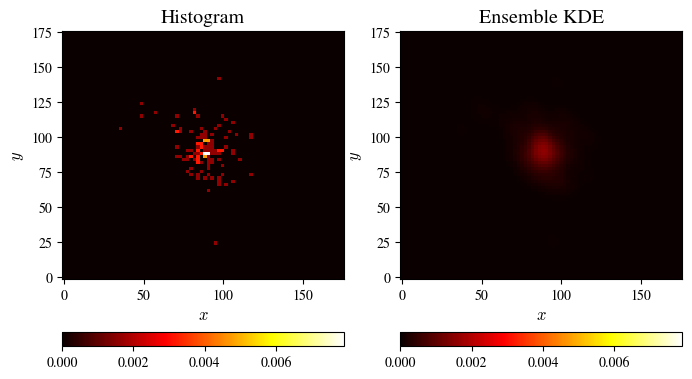

In [ ]:
# Histogram comparison
thyme = 1

fig,ax = plt.subplots(1,2, figsize=(8, 4.6))
pcm0 = ax[0].pcolormesh(X, Y, U_h[:,:,thyme], cmap='hot')
plt.colorbar(pcm0, orientation='horizontal')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$y$')
ax[0].set_title('Histogram')

pcm1 = ax[1].pcolormesh(X, Y, U[:,:,thyme], cmap='hot', vmax=U_h[:,:,thyme].max())
plt.colorbar(pcm1, orientation='horizontal')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
ax[1].set_title('Ensemble KDE')

del fig, ax, pcm0, pcm1, thyme

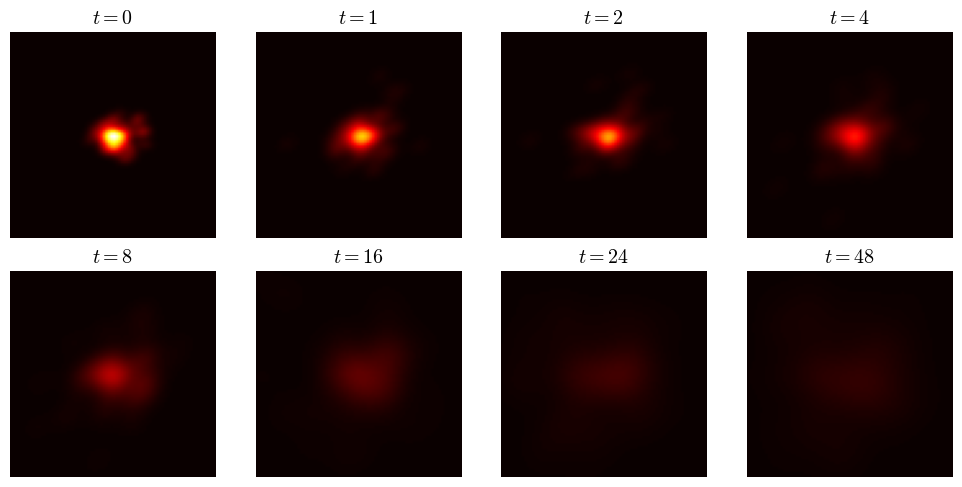

In [ ]:
# SNAPSHOTS
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
vmax = U.max()

for i in range(8):
  ax = axes[i // 4, i % 4]
  im = ax.imshow(U[:, :, i], cmap='hot', vmin=0, vmax=vmax)
  ax.set_title(f'$t={t[i]}$')
  ax.axis('off')
plt.tight_layout()
plt.show()

## Time Interpolation

In [ ]:
# Finer time grid
t_new = np.linspace(t[0], t[-1], 49*2)
dt = np.diff(t_new)[0]

In [ ]:
# Spline interpolation
from scipy.interpolate import make_interp_spline

t_spline = make_interp_spline(t, U.numpy(), k=1, axis=2)
U_interp = torch.from_numpy(np.maximum(t_spline(t_new),0))

# Plant type
USG_interp = []
for u in [US, UG]:
  t_spline = make_interp_spline(t, u.numpy(), k=1, axis=2)
  USG_interp.append(torch.from_numpy(np.maximum(t_spline(t_new),0)))
US_interp, UG_interp = USG_interp

# Infection status
UNI_interp = []
for u in [UN, UI]:
  t_spline = make_interp_spline(t, u.numpy(), k=1, axis=2)
  UNI_interp.append(torch.from_numpy(np.maximum(t_spline(t_new),0)))
UN_interp, UI_interp = UNI_interp

# Control populations
Ui_interp = []
for u in [U1, U2, U3, U4]:
  t_spline = make_interp_spline(t, u.numpy(), k=1, axis=2)
  Ui_interp.append(torch.from_numpy(np.maximum(t_spline(t_new),0)))
U1_interp, U2_interp, U3_interp, U4_interp = Ui_interp

# Check normalization
print((dx*dy*U_interp[:,:,0]).sum().item())

print(U.shape)
print(U_interp.shape)

del USG_interp, UNI_interp, Ui_interp

0.9999999999999989
torch.Size([80, 80, 8])
torch.Size([80, 80, 98])


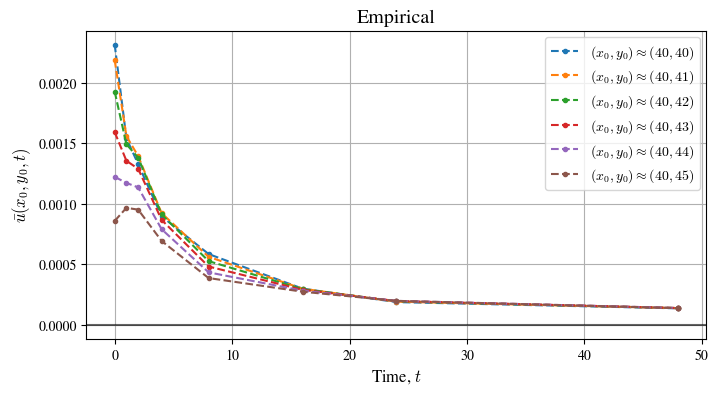

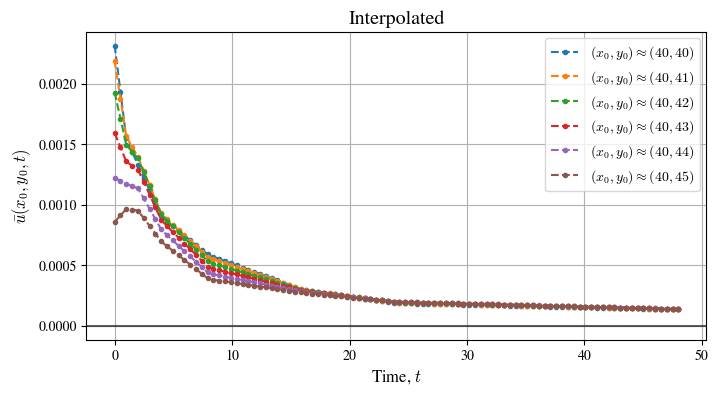

In [ ]:
# LOCAL AVERAGES
def local_average(U, xi, yi, r):
  local = U[max(xi-r,0):min(xi+r+1,U.shape[0]), max(yi-r,0):min(yi+r+1,U.shape[1]), :]
  return local.mean(dim=(0,1))

radius = 0 # No averaging
points = [(40,40), (40,41), (40,42), (40,43), (40,44), (40,45)]
#points = [(40,40), (41,40), (42,40), (43,40), (44,40), (45,40)]

for ind,u in enumerate([U,U_interp]):
  plt.figure(figsize=(8, 4))
  for (xi, yi) in points:
    local = local_average(u, xi, yi, radius)
    plt.plot([t, t_new][ind], local, '.--', label=f'$(x_0,y_0) \\approx ({xi},{yi})$')
  plt.axhline(y=0, color='k', alpha=0.6)
  plt.legend(fontsize=10)
  plt.grid(True)
  plt.title(['Empirical', 'Interpolated'][ind])
  plt.xlabel(r'Time, $t$')
  plt.ylabel(r'$\bar{u}(x_0,y_0,t)$')
  plt.show()

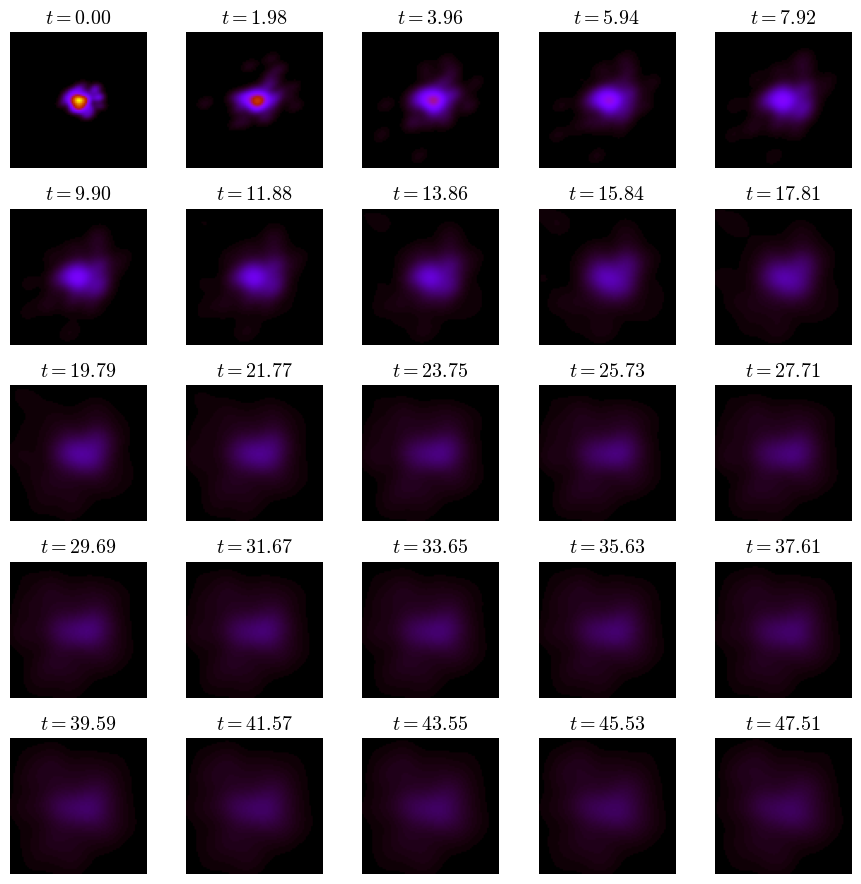

In [ ]:
# INTERPOLATED SNAPSHOTS
fig, axes = plt.subplots(5, 5, figsize=(9, 9))
vmax = U_interp.max()

for i in range(25):
  ax = axes[i // 5, i % 5]
  im = ax.imshow(U_interp[:, :, 4*i], cmap='gnuplot', vmin=0, vmax=vmax)
  ax.set_title(f'$t={t_new[4*i]:.2f}$')
  ax.axis('off')
plt.tight_layout()
plt.show()

## SG filter for $u(r,t)$

In [ ]:
# # Additional SG filter
# from scipy.signal import savgol_filter as SG

# window = 7
# poly = 3

# Ur = SG(Ur_h, window, poly, axis=0)

# Ur1 = SG(Ur1_h, window, poly, axis=0)
# Ur2 = SG(Ur2_h, window, poly, axis=0)
# Ur3 = SG(Ur3_h, window, poly, axis=0)
# Ur4 = SG(Ur4_h, window, poly, axis=0)

In [ ]:
# plt.figure(figsize=(7,4))
# for i,ti in enumerate(t):
#   plt.plot(r, Ur[:,i], '-', color='red', alpha=6/8-i/15, label=f'$t={ti}$')
#   plt.plot(r, Ur[:,i], '.', markersize=2, color='k', alpha=6/8-i/15)
# plt.xlabel('$r$')
# plt.ylabel('$u(r,t)$')
# plt.legend()
# plt.show()

In [ ]:
# # Histogram comparison (radial)
# fig,ax = plt.subplots(1,2, figsize=(8, 4.6))

# pcm0 = ax[0].pcolormesh(t, r, Ur_h, cmap='turbo')
# plt.colorbar(pcm0, orientation='horizontal')
# ax[0].set_xlabel('$t$')
# ax[0].set_ylabel('$r$')
# ax[0].set_title('Histogram')

# pcm1 = ax[1].pcolormesh(t, r, Ur, cmap='turbo', vmax=Ur_h.max())
# plt.colorbar(pcm1, orientation='horizontal')
# ax[1].set_xlabel('$t$')
# ax[1].set_ylabel('$r$')
# ax[1].set_title('SG Filter')

# del fig, ax, pcm0, pcm1

# Data analysis

Violin plots of `horizontal`

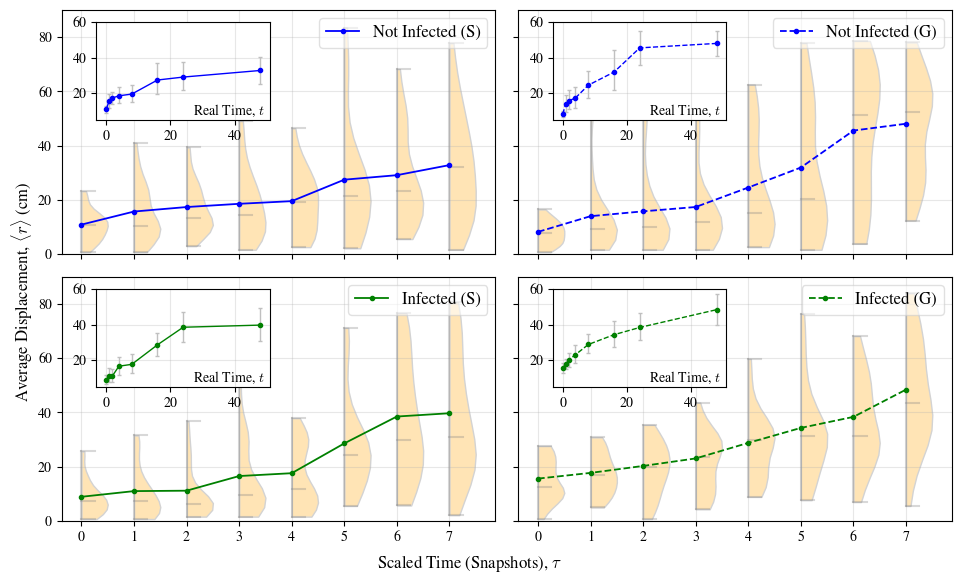

In [ ]:
from scipy import stats
fig, axes = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True)

datasets = [cats1, cats2, cats3, cats4]
titles = ['Not Infected (S)', 'Not Infected (G)', 'Infected (S)', 'Infected (G)']
colors = ['Blue', 'Blue', 'Green', 'Green']
styles = ['-', '--', '-', '--']

for ax, df, title, color, style in zip(axes.flat, datasets, titles, colors, styles):
  df = df.sort_values('Time')
  inset_ax = ax.inset_axes([0.08, 0.55, 0.4, 0.4]) # [x0, y0, W, H]

  means = []
  CIs_lower = []
  CIs_upper = []

  for i, ti in enumerate(t):
    data_slice = df[df['Time'] == ti]['horizontal'].dropna()

    # Boostrap confidence intervals
    n = len(data_slice)
    boots = 1000
    mean = np.mean(data_slice)
    means.append(mean)
    bootstrap_means = np.random.choice(data_slice, (n,boots)).mean(axis=0)
    CIs_lower.append(mean - np.percentile(bootstrap_means, 2.5))
    CIs_upper.append(np.percentile(bootstrap_means, 97.5) - mean)

    # Clip long tails
    lower = np.percentile(data_slice, 0)
    upper = np.percentile(data_slice, 97.5)
    data_clipped = data_slice[(data_slice >= lower) & (data_slice <= upper)]

    # Main violin plot with rescaled time (tau)
    parts = ax.violinplot(dataset=data_clipped, positions=[tau[i]], widths=1,
                          showmedians=True, showextrema=True, side='high', points=15)

    for pc in parts['bodies']:
      pc.set_facecolor('moccasin')
      pc.set_edgecolor('lightgray')
      pc.set_alpha(1)
    parts['cmins'].set_alpha(0.3)
    parts['cmins'].set_color('gray')
    parts['cmedians'].set_alpha(0.3)
    parts['cmedians'].set_color('gray')
    parts['cmaxes'].set_alpha(0.3)
    parts['cmaxes'].set_color('gray')
    parts['cbars'].set_alpha(0.3)
    parts['cbars'].set_color('gray')

  CIs = np.array([CIs_lower, CIs_upper])

  # Main plot mean line
  ax.plot(tau, means, markersize=6, ls=style, color=color, marker='.', linewidth=1.3, label=title)
  ax.grid(True, which='both', linestyle='-', alpha=0.3)
  ax.legend(loc='upper right', framealpha=0.6)

  # Inset panel
  inset_ax.errorbar(t, means, yerr=CIs, markersize=6, ls=style, color=color,
                    marker='.', linewidth=1, capsize=1.5, ecolor='silver')
  inset_ax.grid(True, alpha=0.3)
  inset_ax.set_xlim(min(t)-3, max(t)+3)
  inset_ax.set_ylim(5, 60)
  inset_ax.text(27.0, 7.5, r'Real Time, $t$', fontsize=10)

fig.text(0.5, 0.04, r'Scaled Time (Snapshots), $\tau$', ha='center')
fig.text(0.04, 0.5, r'Average Displacement, $\langle{r}\rangle$ (cm)', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.ylim([0, 90])
plt.show()

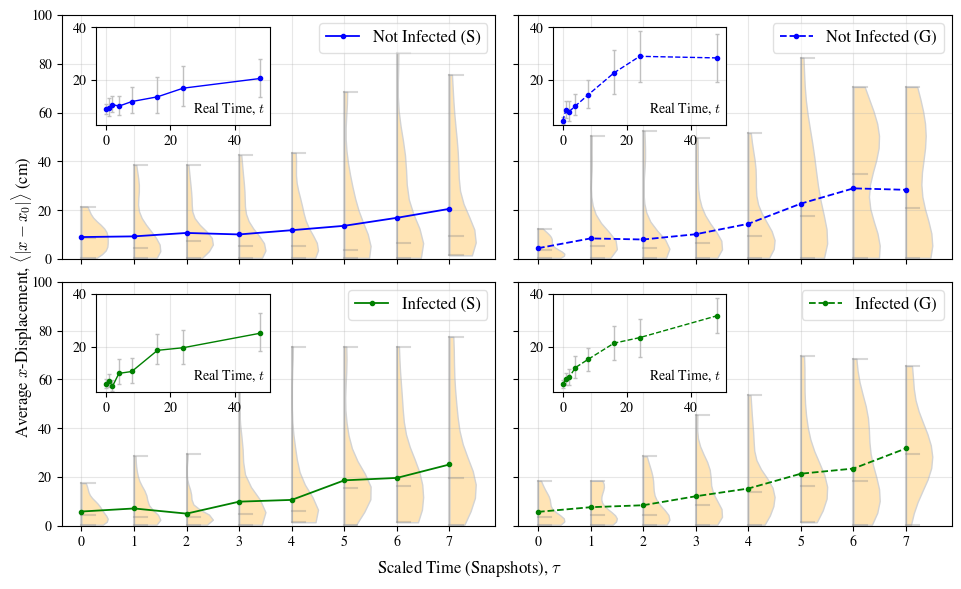

In [ ]:
from scipy import stats
fig, axes = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True)

datasets = [cats1, cats2, cats3, cats4]
titles = ['Not Infected (S)', 'Not Infected (G)', 'Infected (S)', 'Infected (G)']
colors = ['Blue', 'Blue', 'Green', 'Green']
styles = ['-', '--', '-', '--']

for ax, df, title, color, style in zip(axes.flat, datasets, titles, colors, styles):
  df = df.sort_values('Time')
  inset_ax = ax.inset_axes([0.08, 0.55, 0.4, 0.4]) # [x0, y0, W, H]

  means = []
  CIs_lower = []
  CIs_upper = []

  for i, ti in enumerate(t):
    #data_slice = df[df['Time'] == ti]['horizontal'].dropna()
    data_slice = np.abs(df[df['Time'] == ti]['X'].dropna() - 175/2)

    # Boostrap confidence intervals
    n = len(data_slice)
    boots = 1000
    mean = np.mean(data_slice)
    means.append(mean)
    bootstrap_means = np.random.choice(data_slice, (n,boots)).mean(axis=0)
    CIs_lower.append(mean - np.percentile(bootstrap_means, 2.5))
    CIs_upper.append(np.percentile(bootstrap_means, 97.5) - mean)

    # Clip long tails
    lower = np.percentile(data_slice, 0)
    upper = np.percentile(data_slice, 100)#97.5)
    data_clipped = data_slice[(data_slice >= lower) & (data_slice <= upper)]

    # Main violin plot with rescaled time (tau)
    parts = ax.violinplot(dataset=data_clipped, positions=[tau[i]], widths=1,
                          showmedians=True, showextrema=True, side='high', points=15)

    for pc in parts['bodies']:
      pc.set_facecolor('moccasin')
      pc.set_edgecolor('lightgray')
      pc.set_alpha(1)
    parts['cmins'].set_alpha(0.3)
    parts['cmins'].set_color('gray')
    parts['cmedians'].set_alpha(0.3)
    parts['cmedians'].set_color('gray')
    parts['cmaxes'].set_alpha(0.3)
    parts['cmaxes'].set_color('gray')
    parts['cbars'].set_alpha(0.3)
    parts['cbars'].set_color('gray')

  CIs = np.array([CIs_lower, CIs_upper])

  # Main plot mean line
  ax.plot(tau, means, markersize=6, ls=style, color=color, marker='.', linewidth=1.3, label=title)
  ax.grid(True, which='both', linestyle='-', alpha=0.3)
  ax.legend(loc='upper right', framealpha=0.6)

  # Inset panel
  inset_ax.errorbar(t, means, yerr=CIs, markersize=6, ls=style, color=color,
                    marker='.', linewidth=1, capsize=1.5, ecolor='silver')
  inset_ax.grid(True, alpha=0.3)
  inset_ax.set_xlim(min(t)-3, max(t)+3)
  inset_ax.set_ylim(3, 40)
  inset_ax.text(27.0, 7.5, r'Real Time, $t$', fontsize=10)

fig.text(0.5, 0.04, r'Scaled Time (Snapshots), $\tau$', ha='center')
fig.text(0.04, 0.5, r'Average $x$-Displacement, $\langle{|x-x_0|}\rangle$ (cm)', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.ylim([0, 100])
plt.show()

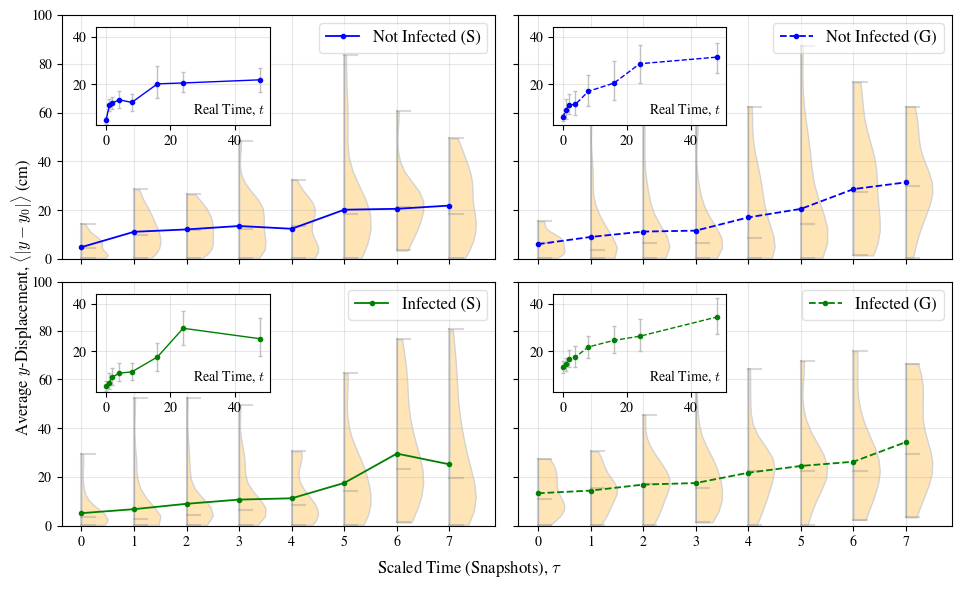

In [ ]:
from scipy import stats
fig, axes = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True)

datasets = [cats1, cats2, cats3, cats4]
titles = ['Not Infected (S)', 'Not Infected (G)', 'Infected (S)', 'Infected (G)']
colors = ['Blue', 'Blue', 'Green', 'Green']
styles = ['-', '--', '-', '--']

for ax, df, title, color, style in zip(axes.flat, datasets, titles, colors, styles):
  df = df.sort_values('Time')
  inset_ax = ax.inset_axes([0.08, 0.55, 0.4, 0.4]) # [x0, y0, W, H]

  means = []
  CIs_lower = []
  CIs_upper = []

  for i, ti in enumerate(t):
    #data_slice = df[df['Time'] == ti]['horizontal'].dropna()
    data_slice = np.abs(df[df['Time'] == ti]['Y'].dropna() - 175/2)

    # Boostrap confidence intervals
    n = len(data_slice)
    boots = 1000
    mean = np.mean(data_slice)
    means.append(mean)
    bootstrap_means = np.random.choice(data_slice, (n,boots)).mean(axis=0)
    CIs_lower.append(mean - np.percentile(bootstrap_means, 2.5))
    CIs_upper.append(np.percentile(bootstrap_means, 97.5) - mean)

    # Clip long tails
    lower = np.percentile(data_slice, 0)
    upper = np.percentile(data_slice, 100)#97.5)
    data_clipped = data_slice[(data_slice >= lower) & (data_slice <= upper)]

    # Main violin plot with rescaled time (tau)
    parts = ax.violinplot(dataset=data_clipped, positions=[tau[i]], widths=1,
                          showmedians=True, showextrema=True, side='high', points=15)

    for pc in parts['bodies']:
      pc.set_facecolor('moccasin')
      pc.set_edgecolor('lightgray')
      pc.set_alpha(1)
    parts['cmins'].set_alpha(0.3)
    parts['cmins'].set_color('gray')
    parts['cmedians'].set_alpha(0.3)
    parts['cmedians'].set_color('gray')
    parts['cmaxes'].set_alpha(0.3)
    parts['cmaxes'].set_color('gray')
    parts['cbars'].set_alpha(0.3)
    parts['cbars'].set_color('gray')

  CIs = np.array([CIs_lower, CIs_upper])

  # Main plot mean line
  ax.plot(tau, means, markersize=6, ls=style, color=color, marker='.', linewidth=1.3, label=title)
  ax.grid(True, which='both', linestyle='-', alpha=0.3)
  ax.legend(loc='upper right', framealpha=0.6)

  # Inset panel
  inset_ax.errorbar(t, means, yerr=CIs, markersize=6, ls=style, color=color,
                    marker='.', linewidth=1, capsize=1.5, ecolor='silver')
  inset_ax.grid(True, alpha=0.3)
  inset_ax.set_xlim(min(t)-3, max(t)+3)
  inset_ax.set_ylim(3, 44)
  inset_ax.text(27.0, 7.5, r'Real Time, $t$', fontsize=10)

fig.text(0.5, 0.04, r'Scaled Time (Snapshots), $\tau$', ha='center')
fig.text(0.04, 0.5, r'Average $y$-Displacement, $\langle{|y-y_0|}\rangle$ (cm)', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.ylim([0, 100])
plt.show()

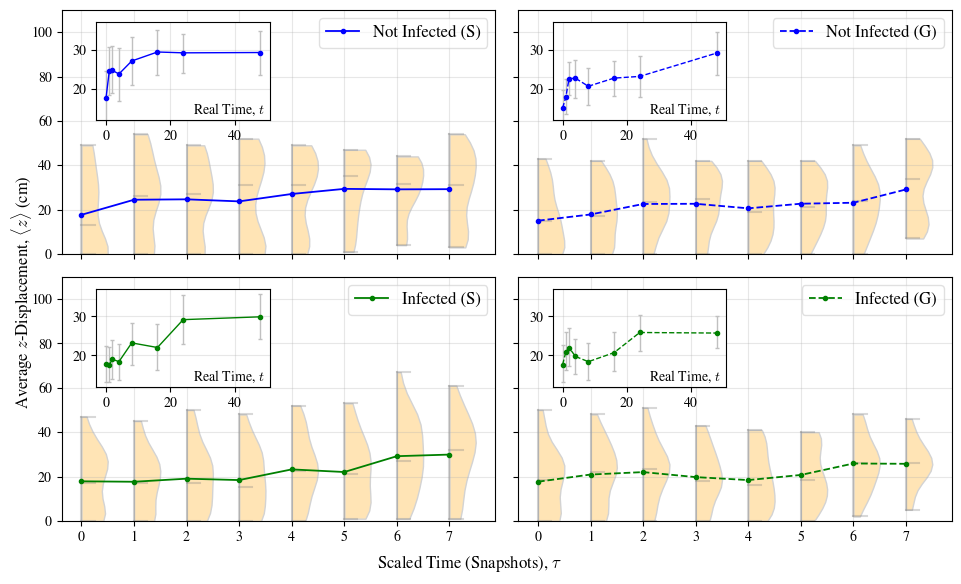

In [ ]:
from scipy import stats
fig, axes = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True)

datasets = [cats1, cats2, cats3, cats4]
titles = ['Not Infected (S)', 'Not Infected (G)', 'Infected (S)', 'Infected (G)']
colors = ['Blue', 'Blue', 'Green', 'Green']
styles = ['-', '--', '-', '--']

for ax, df, title, color, style in zip(axes.flat, datasets, titles, colors, styles):
  df = df.sort_values('Time')
  inset_ax = ax.inset_axes([0.08, 0.55, 0.4, 0.4]) # [x0, y0, W, H]

  means = []
  CIs_lower = []
  CIs_upper = []

  for i, ti in enumerate(t):
    #data_slice = df[df['Time'] == ti]['horizontal'].dropna()
    data_slice = df[(df['Time'] == ti) & (df['Z'] <= 70)]['Z'].dropna()

    # Boostrap confidence intervals
    n = len(data_slice)
    boots = 1000
    mean = np.mean(data_slice)
    means.append(mean)
    bootstrap_means = np.random.choice(data_slice, (n,boots)).mean(axis=0)
    CIs_lower.append(mean - np.percentile(bootstrap_means, 2.5))
    CIs_upper.append(np.percentile(bootstrap_means, 97.5) - mean)

    # Clip long tails
    lower = np.percentile(data_slice, 0)
    upper = np.percentile(data_slice, 100)#97.5)
    data_clipped = data_slice[(data_slice >= lower) & (data_slice <= upper)]

    # Main violin plot with rescaled time (tau)
    parts = ax.violinplot(dataset=data_clipped, positions=[tau[i]], widths=1,
                          showmedians=True, showextrema=True, side='high', points=15)

    for pc in parts['bodies']:
      pc.set_facecolor('moccasin')
      pc.set_edgecolor('lightgray')
      pc.set_alpha(1)
    parts['cmins'].set_alpha(0.3)
    parts['cmins'].set_color('gray')
    parts['cmedians'].set_alpha(0.3)
    parts['cmedians'].set_color('gray')
    parts['cmaxes'].set_alpha(0.3)
    parts['cmaxes'].set_color('gray')
    parts['cbars'].set_alpha(0.3)
    parts['cbars'].set_color('gray')

  CIs = np.array([CIs_lower, CIs_upper])

  # Main plot mean line
  ax.plot(tau, means, markersize=6, ls=style, color=color, marker='.', linewidth=1.3, label=title)
  ax.grid(True, which='both', linestyle='-', alpha=0.3)
  ax.legend(loc='upper right', framealpha=0.6)

  # Inset panel
  inset_ax.errorbar(t, means, yerr=CIs, markersize=6, ls=style, color=color,
                    marker='.', linewidth=1, capsize=1.5, ecolor='silver')
  inset_ax.grid(True, alpha=0.3)
  inset_ax.set_xlim(min(t)-3, max(t)+3)
  inset_ax.set_ylim(12, 37)
  inset_ax.text(27.0, 13.5, r'Real Time, $t$', fontsize=10)

fig.text(0.5, 0.04, r'Scaled Time (Snapshots), $\tau$', ha='center')
fig.text(0.04, 0.5, r'Average $z$-Displacement, $\langle{z}\rangle$ (cm)', va='center', rotation='vertical')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.ylim([0, 110])
plt.show()

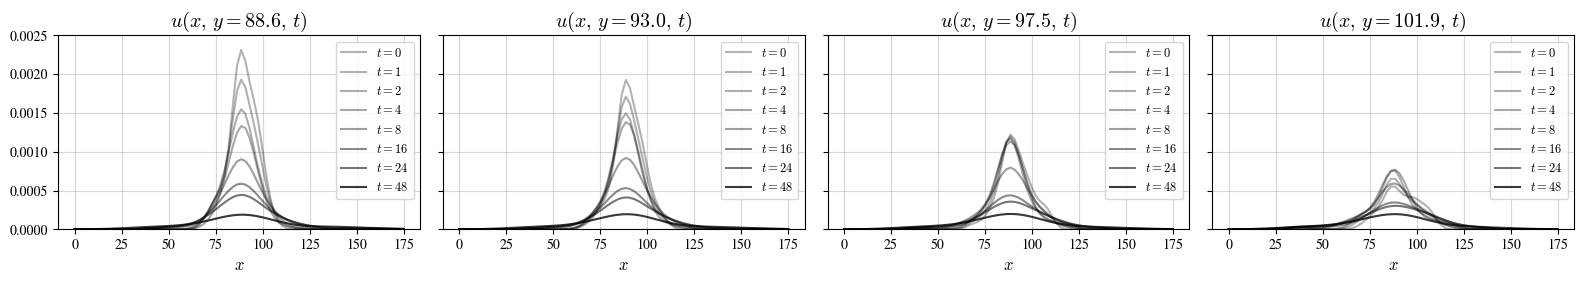

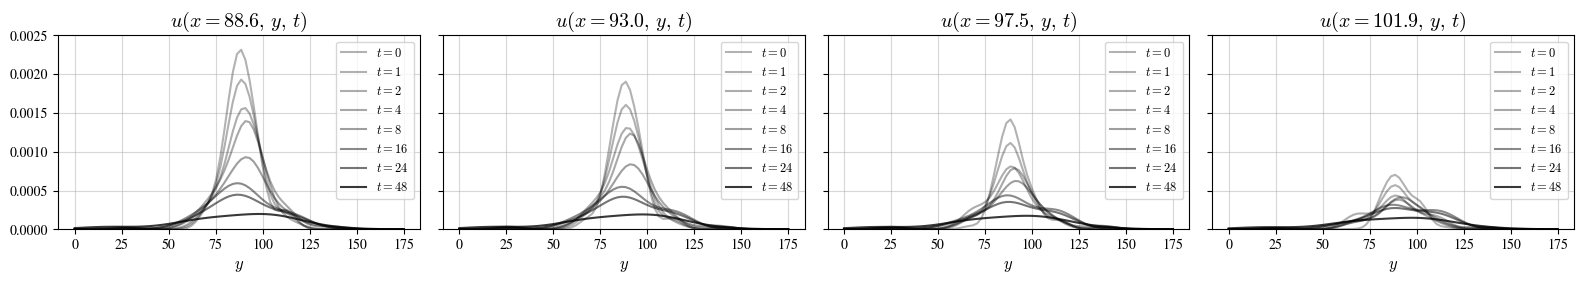

In [ ]:
# PLOT SLICES
#indices = [40, 45, 50, 55]
indices = [40, 42, 44, 46]

# Plot along x-axis
fig, axs = plt.subplots(1,4, figsize=(16,3), sharey=True)
for i,yi in enumerate(indices):
  ax = axs[i]
  for ti in t:
    ax.plot(x, U_interp[:,yi,ti], 'k', alpha=ti/100+0.3, label=f'$t={ti}$')
  ax.set_ylim([0, 0.0025])
  ax.set_xlabel('$x$')
  ax.set_title(f'$u(x,\,y={y[yi]:.1f},\,t)$')
  ax.grid(True, alpha=0.5)
  ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

# Plot along y-axis
fig, axs = plt.subplots(1, 4, figsize=(16,3), sharey=True)
for i,xi in enumerate(indices):
  ax = axs[i]
  for ti in t:
    ax.plot(x, U_interp[xi,:,ti], 'k', alpha=ti/100+0.3, label=f'$t={ti}$')
  ax.set_ylim([0, 0.0025])
  ax.set_xlabel('$y$')
  ax.set_title(f'$u(x={x[xi]:.1f},\,y,\,t)$')
  ax.grid(True, alpha=0.5)
  ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

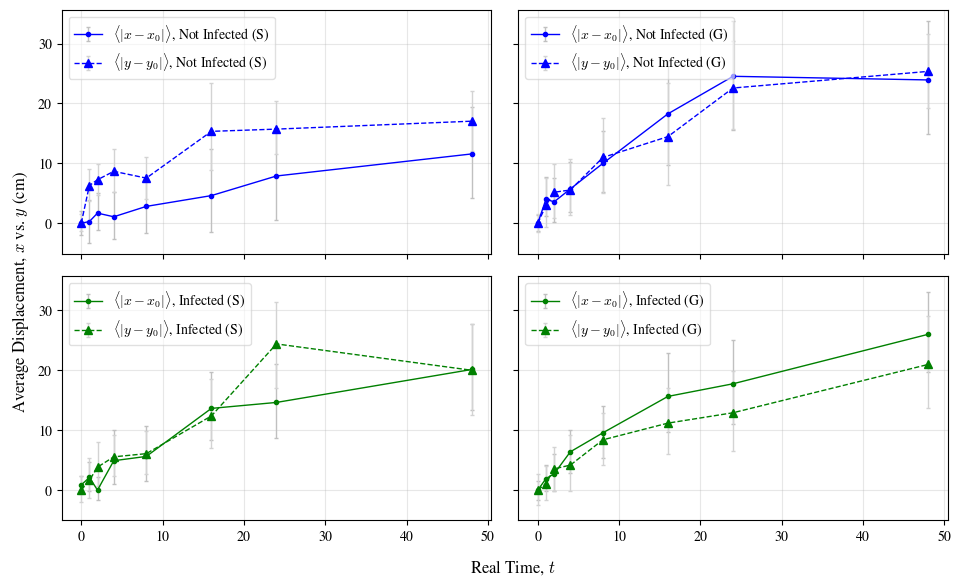

In [ ]:
from scipy import stats
fig, axes = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=True)

datasets = [cats1, cats2, cats3, cats4]
titles = ['Not Infected (S)', 'Not Infected (G)', 'Infected (S)', 'Infected (G)']
colors = ['Blue', 'Blue', 'Green', 'Green']
styles = ['-', '--', '-', '--']

for ax, df, title, color, style in zip(axes.flat, datasets, titles, colors, styles):
  df = df.sort_values('Time')

  means_x = []
  CIs_lower_x = []
  CIs_upper_x = []

  means_y = []
  CIs_lower_y = []
  CIs_upper_y = []

  for i, ti in enumerate(t):
    data_slice_x = np.abs(df[df['Time'] == ti]['X'].dropna() - 175/2)
    data_slice_y = np.abs(df[df['Time'] == ti]['Y'].dropna() - 175/2)

    # Boostrap confidence intervals
    n = len(data_slice_x)
    boots = 1000

    mean_x = np.mean(data_slice_x)
    means_x.append(mean_x)
    bootstrap_means_x = np.random.choice(data_slice_x, (n,boots)).mean(axis=0)
    CIs_lower_x.append(mean_x - np.percentile(bootstrap_means_x, 2.5))
    CIs_upper_x.append(np.percentile(bootstrap_means_x, 97.5) - mean_x)

    mean_y = np.mean(data_slice_y)
    means_y.append(mean_y)
    bootstrap_means_y = np.random.choice(data_slice_y, (n,boots)).mean(axis=0)
    CIs_lower_y.append(mean_y - np.percentile(bootstrap_means_y, 2.5))
    CIs_upper_y.append(np.percentile(bootstrap_means_y, 97.5) - mean_y)

  CIs_x = np.array([CIs_lower_x, CIs_upper_x])
  CIs_y = np.array([CIs_lower_y, CIs_upper_y])

  # Confidence intervals
  ax.errorbar(t, means_x-min(means_x), yerr=CIs_x, markersize=6, ls='-', color=color, marker='.',
              linewidth=1, capsize=1.5, ecolor='silver', label=r'$\langle{|x-x_0|}\rangle$, '+title)
  ax.errorbar(t, means_y-min(means_y), yerr=CIs_y, markersize=6, ls='--', color=color, marker='^',
              linewidth=1, capsize=1.5, ecolor='lightgray', label=r'$\langle{|y-y_0|}\rangle$, '+title)
  ax.grid(True, which='both', linestyle='-', alpha=0.3)
  ax.legend(loc='upper left', framealpha=0.6, fontsize=10)
  #ax.set_xlim(min(t)-3, max(t)+3)
  #ax.set_ylim(3, 40)

fig.text(0.04, 0.5, r'Average Displacement, $x$ vs. $y$ (cm)', va='center', rotation='vertical')
fig.text(0.5, 0.04, r'Real Time, $t$', va='center')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
#plt.ylim([0, 100])
plt.show()

\begin{align*}
\langle (x_i-\mu_i) (x_j - \mu_j) \rangle = \int\!\!\!\int_{\Omega} (x_i-\mu_i) (x_j - \mu_j) \, u(x,t) \, dx \, dy = 4D_{ij}t
\end{align*}

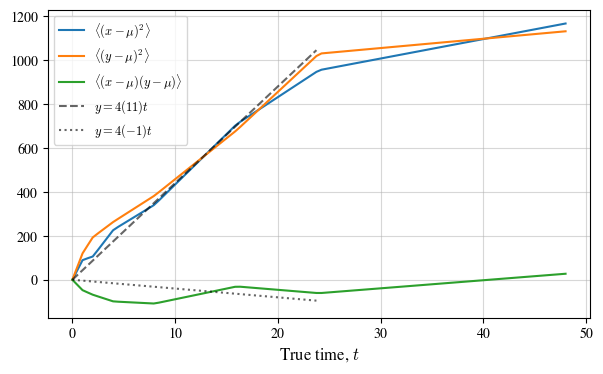

In [ ]:
Unp = U_interp.numpy()
#Unp = U1_interp.numpy()

Xc = X - 175/2
Yc = Y - 175/2

avg_xc = [((Xc**2) * Unp[:,:,tn]).sum()*(dx*dy).numpy() for tn in range(Unp.shape[-1])]
avg_yc = [((Yc**2) * Unp[:,:,tn]).sum()*(dx*dy).numpy() for tn in range(Unp.shape[-1])]
avg_xyc = [((Xc*Yc) * Unp[:,:,tn]).sum()*(dx*dy).numpy() for tn in range(Unp.shape[-1])]

plt.figure(figsize=(7,4))
plt.plot(t_new, avg_xc-(avg_xc[0]), label=r'$\langle(x-\mu)^2\rangle$')
plt.plot(t_new, avg_yc-(avg_yc[0]), label=r'$\langle(y-\mu)^2\rangle$')
plt.plot(t_new, avg_xyc-(avg_xyc[0]), label=r'$\langle(x-\mu)(y-\mu)\rangle$')
plt.plot(t_new[:49], 4*11*t_new[:49], ls='--', color='k', alpha=0.6, label='$y=4(11)t$')
plt.plot(t_new[:49], 4*(-1)*t_new[:49], ls=':', color='k', alpha=0.6, label='$y=4(-1)t$')
plt.xlabel('True time, $t$')
plt.grid(True, alpha=0.5)
plt.legend(fontsize=9)
#plt.yscale('log')
plt.show()

\begin{align*}
4\hat{D}_{ij}t
:= \int\!\!\!\int_{\Omega} (x_i-\mu_i) (x_j - \mu_j) \, \mu(\mathbf{X}_t) \, dx \, dy
 = \frac{1}{N_t} \sum_{n=1}^{N_t} \big(\mathbf{x}_t^n - \boldsymbol{\mu}_t^n\big)_i \big(\mathbf{x}_t^n - \boldsymbol{\mu}_t^n\big)_j
\end{align*}

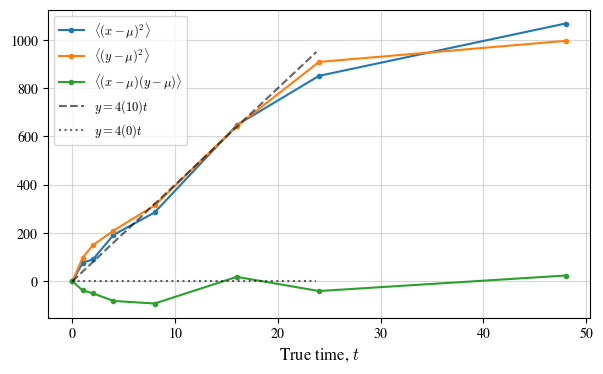

In [ ]:
avg_xc = [((cats[cats['Time'] == t[i]]['X']-np.mean(cats[cats['Time'] == t[i]]['X']))**2).mean() for i in range(8)]
avg_yc = [((cats[cats['Time'] == t[i]]['Y']-np.mean(cats[cats['Time'] == t[i]]['Y']))**2).mean() for i in range(8)]
avg_xyc = [((cats[cats['Time'] == t[i]]['X']-np.mean(cats[cats['Time'] == t[i]]['X'])) *
           (cats[cats['Time'] == t[i]]['Y']-np.mean(cats[cats['Time'] == t[i]]['Y']))).mean() for i in range(8)]

plt.figure(figsize=(7,4))
plt.plot(t, avg_xc-(avg_xc[0]), '.-', label=r'$\langle(x-\mu)^2\rangle$')
plt.plot(t, avg_yc-(avg_yc[0]), '.-', label=r'$\langle(y-\mu)^2\rangle$')
plt.plot(t, avg_xyc-(avg_xyc[0]), '.-', label=r'$\langle(x-\mu)(y-\mu)\rangle$')
plt.plot(t_new[:49], 4*10*t_new[:49], ls='--', color='k', alpha=0.6, label='$y=4(10)t$')
plt.plot(t_new[:49], 4*(0)*t_new[:49], ls=':', color='k', alpha=0.6, label='$y=4(0)t$')
plt.xlabel('True time, $t$')
plt.grid(True, alpha=0.5)
plt.legend(fontsize=9)
#plt.yscale('log')
plt.show()

# Learned dynamics

In [ ]:
# PICK DATASET
# Ensemble
#U_ws = U_interp.clone()

# Grouped by plant tpye or infection stateus
#U_ws = US_interp.clone() # Plant type = S
#U_ws = UG_interp.clone() # Plant type = G
#U_ws = UN_interp.clone() # Infection = N
#U_ws = UI_interp.clone() # Infection = I

# Separate control populations
#U_ws = U1_interp.clone() # S,N
#U_ws = U2_interp.clone() # G,N
#U_ws = U3_interp.clone() # S,I
U_ws = U4_interp.clone() # G,I

# Grid
try:
  t = torch.from_numpy(t)
  t_new = torch.from_numpy(t_new)
except:
  pass

X2,Y2 = torch.meshgrid(x,y, indexing='ij')
X,Y,T = torch.meshgrid(x,y,t_new, indexing='ij')

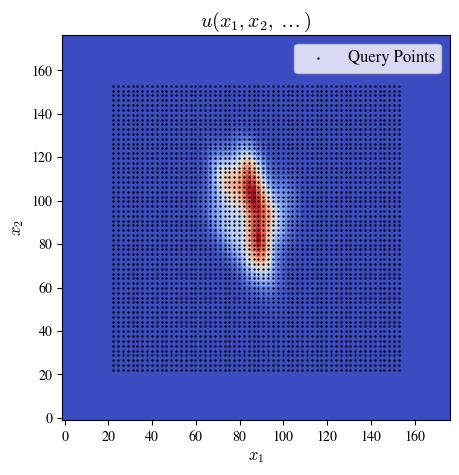

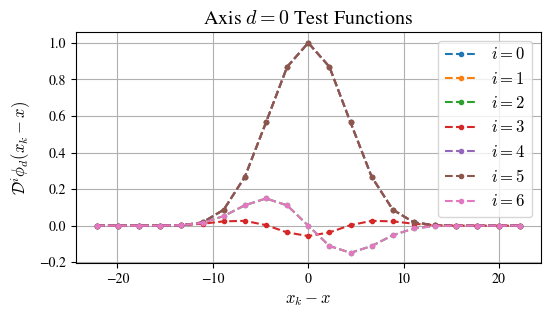

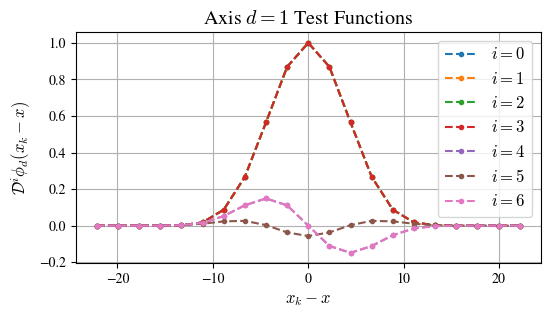

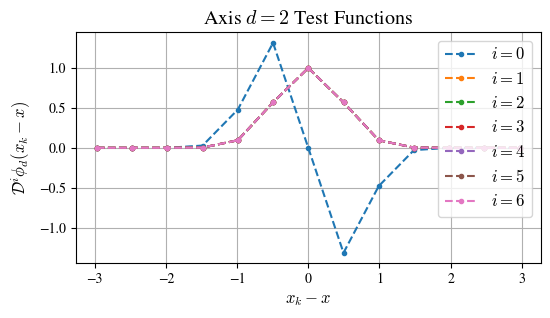

In [ ]:
coords = [x, y, t_new]
vars = []
names = ['u']

# m = [6, 6, 5] # (+/- MATCHES SPECTRUM)
#m = [8, 8, 6]
m = [10, 10, 6] # (GOOD FFT MATCH)
#m = [12, 12, 6]
#m = [12, 12, 8] # (DECENT MATCH)
#m = [21, 21, 15] # w1/w2 (BAD FFT MATCH)
s = [1, 1, 1]

# Derivatives for test fcns
alpha = [
    [0,0,1], # d/dt (lhs)
    [0,0,0], # 1
    [1,0,0], # d/dx
    [2,0,0], # d^2/dx^2
    [0,1,0], # d/dy
    [0,2,0], # d^2/dy^2
    [1,1,0], # d^2/dxdy
]

# Powers for homogeneous fcns
beta = [[0],
        [1]]
# beta = [[0],
#         [1],
#         [2]]

# Hyper-params
params = {
    'V': vars,
    'names': names,
    'm': m,
    's': s,
    #'tau_hat': 1,
    'rescale': False,
    #'rescale': True,
}

model = WSINDy(U_ws, alpha, beta, coords, **params)

In [ ]:
# Set lhs
lhs_name = 'u' + model.derivative_names[0]
model.build_lhs(lhs_name)

# Create standard library terms
[G, powers, derivs, rhs_names] = model.create_default_library()
[G, powers, derivs, rhs_names] = [G[1:], powers[1:], derivs[1:], rhs_names[1:]]
G_mat = torch.stack(G).T

# Print out symbolic library
lib_string = r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'
display(Math(lib_string))

print(f'Library shape: G = {G_mat.numpy().shape}')
print(f'Condition number: K(G) = {la.cond(G_mat):.2e}\n')

100%|██████████| 6/6 [00:00<00:00, 12.37it/s]


<IPython.core.display.Math object>

Library shape: G = (309600, 6)
Condition number: K(G) = 8.58e+02



Customize library

In [ ]:
# Trim out ∇u = (u_x,u_y) terms?
# remove_cols = [1,3]
# print(f'Removing: {rhs_names[1], rhs_names[3]}\n')
# remove_cols = [0,1,3]
# print(f'Removing: {rhs_names[0], rhs_names[1], rhs_names[3]}\n')
remove_cols = [0,1,3,5]
print(f'Removing: {rhs_names[0], rhs_names[1], rhs_names[3], rhs_names[5]}\n')

for column in sorted(remove_cols, reverse=True):
  G.pop(column)
  powers.pop(column)
  derivs.pop(column)
  rhs_names.pop(column)
G_mat = torch.stack(G).T

display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'))
print(f'Library shape: G = {G_mat.numpy().shape}')
print(f'Condition number: K(G) = {la.cond(G_mat):.2e}\n')

del remove_cols,column

Removing: ('(u)', '(u)_{x}', '(u)_{y}', '(u)_{xy}')



<IPython.core.display.Math object>

Library shape: G = (309600, 2)
Condition number: K(G) = 1.97e+00



In [ ]:
# Augment the library to include a single Laplacian term?
# print(f'Combining: {rhs_names[1]}, {rhs_names[2]}\n')

# columns = [1,2]
# coeffs = [1,1]
# name = 'Δu'
# info = [G, powers, derivs, rhs_names]
print(f'Combining: {rhs_names[0]}, {rhs_names[1]}\n')

columns = [0,1]
coeffs = [1,1]
name = 'Δu'
info = [G, powers, derivs, rhs_names]

[G,powers,derivs,rhs_names] = composite_term(columns, coeffs, name, model, info)
G_mat = torch.stack(G).T

display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'))
print(f'Library shape: G = {G_mat.numpy().shape}')
print(f'Condition number: K(G) = {la.cond(G_mat):.2e}\n')

Combining: (u)_{xx}, (u)_{yy}



<IPython.core.display.Math object>

Library shape: G = (309600, 1)
Condition number: K(G) = 1.00e+00



\begin{align*}
V(x,y) = \sum_{n=1}^{N} \sum_{m=1}^M \alpha_{nm}V_{nm}(x,y) = \sum_{n=1}^{N} \sum_{m=1}^M \alpha_{nm} \cos\left(\frac{2\pi n x}{L}\right) \cos\left(\frac{2\pi m y}{W}\right)
\end{align*}

In [ ]:
# # MAKE V TERMS
# freq = 2*np.pi/175

# # Form 2D cosine series terms
# V_nm = lambda n,m: torch.cos(freq*n*X2) * torch.cos(freq*m*Y2)
# Vx_nm = lambda n,m: -(freq*n) * torch.sin(freq*n*X2) * torch.cos(freq*m*Y2)
# Vy_nm = lambda n,m: -(freq*m) * torch.cos(freq*n*X2) * torch.sin(freq*m*Y2)

# # Build weak gradients
# kernel_x = model.kernels[2]
# kernel_y = model.kernels[4]

# UVx_nm = lambda n,m: U_ws * Vx_nm(n,m).unsqueeze(2)
# UVy_nm = lambda n,m: U_ws * Vy_nm(n,m).unsqueeze(2)
# psix_UVx_nm = lambda n,m: compute_weak_poly(UVx_nm(n,m), kernel_x, model.spacing)
# psiy_UVy_nm = lambda n,m: compute_weak_poly(UVy_nm(n,m), kernel_y, model.spacing)

# weak_Vnm_term = lambda n,m: psix_UVx_nm(n,m) + psix_UVx_nm(n,m)

# # Construct Vnm terms and add to library
# [N,M] = [9,9]
# NMs = list(itertools.product(range(1,N+1), range(1,M+1)))

# for n,m in NMs:
#   term = weak_Vnm_term(n,m)
#   G.append(term[model.conv_mask])
#   name = '∇·(u∇V_{' + f'{n}{m}' + '})'
#   rhs_names.append(name)

# # Print out new symbolic library
# lib_string = r'\Theta='+r'\{'+r',\,'.join(rhs_names[:-len(NMs)+2])+',\dots'+r'\}'
# display(Math(lib_string))

# G_mat = torch.stack(G).T
# print(f'Library shape: G = {G_mat.numpy().shape}')
# print(f'Condition number: K(G) = {la.cond(G_mat):.2e}\n')

# # Check aliasing?
# plt.figure(figsize=(3,2.5))
# plt.pcolormesh(X2, Y2, V_nm(9,5), cmap='coolwarm')
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.colorbar(shrink=0.9)
# plt.show()

\begin{align*}
\mathcal{K}(r) = \sum_{n=0}^N \, \beta_n \, \mathcal{K}_n(r) := \sum_{n=0}^N \, \beta_n \, j_n(r/s)
\end{align*}

In [ ]:
# # Pick a U-scale
# slicer = (slice(model.m[0],-model.m[0]),
#           slice(model.m[1],-model.m[1]),
#           slice(model.m[2],-model.m[2]))
# Uc = U_ws[slicer].max().item()
# print(f'Uc = {Uc:.2e}')

In [ ]:
# # MAKE K TERMS
# from scipy.special import spherical_jn

# #scale = 2
# #scale = 4
# scale = 6
# #mult = 1e3
# mult = 1/Uc

# # Radial grid for K(|x-x0|)
# #K_slice = (slice(25,-25,None), slice(25,-25,None))
# K_slice = (slice(30,-30,None), slice(30,-30,None))
# #K_slice = (slice(35,-35,None), slice(35,-35,None))

# XK = (X2[K_slice] - Nx*dx/2).numpy()
# YK = (Y2[K_slice] - Ny*dy/2).numpy()
# RK = np.sqrt(XK**2 + YK**2)
# RK_inv = np.minimum(1/RK, 1)

# # Form spherical Bessel terms
# K_n = lambda n: mult*spherical_jn(n, RK/scale)
# Kx_n = lambda n: mult*(XK*RK_inv/scale) * spherical_jn(n, RK/scale, derivative=True)
# Ky_n = lambda n: mult*(YK*RK_inv/scale) * spherical_jn(n, RK/scale, derivative=True)

# # Build convolution terms
# KxU_n = lambda n: convolve(U_ws, Kx_n(n)[:,:,np.newaxis], mode='same')
# KyU_n = lambda n: convolve(U_ws, Ky_n(n)[:,:,np.newaxis], mode='same')

# # Build weak gradients
# UKxU_n = lambda n: U_ws * torch.from_numpy(KxU_n(n))
# UKyU_n = lambda n: U_ws * torch.from_numpy(KyU_n(n))
# psix_UKxU_n = lambda n: compute_weak_poly(UKxU_n(n), kernel_x, model.spacing)
# psiy_UKyU_n = lambda n: compute_weak_poly(UKyU_n(n), kernel_y, model.spacing)

# weak_Kn_term = lambda n: psix_UKxU_n(n) + psiy_UKyU_n(n)

# # Construct Kn terms and add to library
# NK = 5
# for n in range(NK):
#   term = weak_Kn_term(n)
#   G.append(term[model.conv_mask])
#   name = '∇·u(∇K_{' + f'{n}' + '}*u)'
#   rhs_names.append(name)

# # Print out new symbolic library
# lib_string = lib_string[:-2]+','+r',\,'.join(rhs_names[-NK:-NK+2])+r',\dots\}'
# display(Math(lib_string))

# G_mat = torch.stack(G).T
# print(f'Library shape: G = {G_mat.numpy().shape}')
# print(f'Condition number: K(G) = {la.cond(G_mat):.2e}\n')

# # Check it out
# plt.figure(figsize=(3,2.5))
# plt.pcolormesh(XK, YK, K_n(0), cmap='coolwarm')
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.colorbar(shrink=0.9)
# plt.show()

Solve for model weights

In [ ]:
# Set library
model.set_library(G, powers, derivs, rhs_names)

# Find sparse weights
w = model.MSTLS()
model.print_report()

HYPER-PARAMETERS
m = [10, 10, 6]
p = [14, 14, 20]
s = [1, 1, 1]
Not rescaled.

LIBRARY
Num. query points = 309600
Num. terms = 1
cond(G) = 1.000e+00

RESULTS
PDE: u_{t} = + 8.17Δu
Nonzero terms = 1
Rel. L2 error = 0.860
R^2 = 0.258
Lambda = 1.000e-04
Loss = 1.000


Examine model

In [ ]:
print('Sparse diffusion constants:')
# print(f'Dx = {w[1].item():.2f}')
# print(f'Dxy = {(w[3]/2).item():.2f}')
# print(f'Dy = {w[2].item():.2f}')
# print(f'Dx/Dy = {(w[1]/w[2]).item():.2f}')
print(f'Dx = {w[0].item():.2f}')
print(f'Dxy = {(w[2]/2).item():.2f}')
print(f'Dy = {w[1].item():.2f}')
print(f'Dx/Dy = {(w[0]/w[1]).item():.2f}')

Sparse diffusion constants:
Dx = 8.87
Dxy = 0.00
Dy = 6.60
Dx/Dy = 1.34


In [ ]:
# Print coeffs
print(f'Sparse coeffs:\n {model.coeffs}\n')

# Print PDE
pde = symbolic_pde(model.lhs_name, model.rhs_names, model.coeffs)
display(Math(pde))

Sparse coeffs:
 tensor([8.8739, 6.5988, 0.0000], dtype=torch.float64)



<IPython.core.display.Math object>

In [ ]:
# Compare to LS solution
w_LS = la.lstsq(torch.stack(G).T, model.lhs).solution
r_LS = (model.lhs - model.library @ w_LS).clone()
bbar = model.lhs.mean().clone()
R2_LS = 1 - (r_LS @ r_LS) / ((model.lhs - bbar) @ (model.lhs - bbar))

print(f'LS coeffs:\n {w_LS}\n')
print(f'LS soln R^2: {R2_LS:.3f}')

LS coeffs:
 tensor([8.3285], dtype=torch.float64)

LS soln R^2: 0.656


In [ ]:
print('LS diffusion constants:')
# print(f'Dx = {w_LS[1].item():.2f}')
# print(f'Dxy = {(w_LS[3]/3).item():.2f}')
# print(f'Dy = {w_LS[2].item():.2f}')
# print(f'Dx/Dy = {(w_LS[1]/w_LS[2]).item():.2f}')
print(f'Dx = {w_LS[0].item():.2f}')
print(f'Dxy = {(w_LS[2]/2).item():.2f}')
print(f'Dy = {w_LS[1].item():.2f}')
print(f'Dx/Dy = {(w_LS[0]/w_LS[1]).item():.2f}')

LS diffusion constants:
Dx = 9.11
Dxy = -0.63
Dy = 6.80
Dx/Dy = 1.34


Leptokurtosis in equation residuals

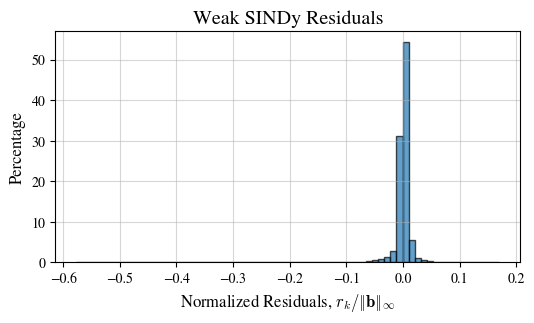

In [ ]:
# Plot residuals, r = b - G*w
r_ws = (model.lhs - model.library @ model.coeffs).clone()
b_inf = abs(model.lhs).max().item()
weights = 100*torch.ones_like(r_ws)/len(r_ws)

plt.figure(figsize=(6,3))
plt.hist(r_ws/b_inf, bins=70, edgecolor='k', alpha=0.7, weights=weights)
plt.xlabel(r'Normalized Residuals, $r_k/|\!|\mathbf{b}|\!|_{\infty}$')
plt.ylabel('Percentage')
plt.title('Weak SINDy Residuals')
plt.grid(True, alpha=0.5)
#plt.yscale('log')
plt.show()

Visualize residuals

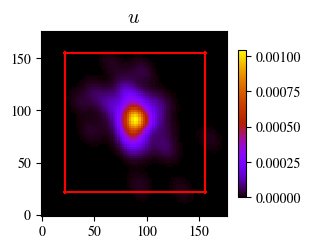

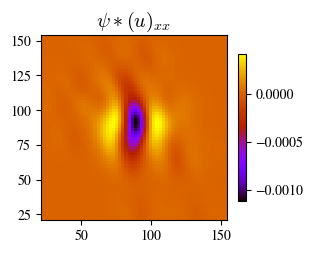

In [ ]:
# Weak form representations
thyme = 1
m = model.m
slicer = tuple([U_ws.shape[i] - 2*m[i] for i in range(len(m))])

# Original data
plt.figure(figsize=(3,2.4))
coords = (X[:,:,0], Y[:,:,0])
plt.pcolormesh(*coords, U_ws[:,:,m[2]+thyme], cmap='gnuplot')

xbox = [x[m[0]].item()/175, x[-m[0]].item()/175]
ybox = [y[m[1]].item()/175, y[-m[1]].item()/175]
plt.axhline(y=y[m[1]], xmin=xbox[0], xmax=xbox[1], color='red')
plt.axhline(y=y[-m[1]], xmin=xbox[0], xmax=xbox[1], color='red')
plt.axvline(x=x[m[0]], ymin=ybox[0], ymax=ybox[1], color='red')
plt.axvline(x=x[-m[0]], ymin=ybox[0], ymax=ybox[1], color='red')

plt.title(f'$u$')
plt.colorbar(shrink=0.8)
plt.show()

# Weak form
plt.figure(figsize=(3,2.4))
coords = (X[m[0]:-m[0], m[1]:-m[1], 0], Y[m[0]:-m[0], m[1]:-m[1], 0])
plt.pcolormesh(*coords, G[0].reshape(slicer)[:,:,thyme], cmap='gnuplot')
plt.title(f'$\psi * {model.rhs_names[0]}$')
plt.colorbar(shrink=0.8)
plt.show()

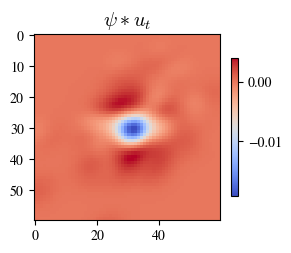

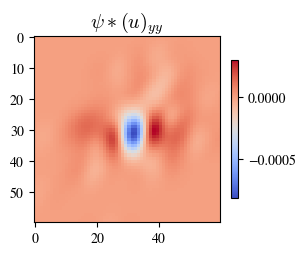

In [ ]:
# Weak form terms
lib_index = 1
#lib_index = -NK+4
thyme = 1

plt.figure(figsize=(3,3))
plt.imshow(model.lhs.reshape(slicer)[:,:,thyme], cmap='coolwarm')
plt.title(f'$\psi * {model.lhs_name}$')
plt.colorbar(shrink=0.6)
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(G[lib_index].reshape(slicer)[:,:,thyme], cmap='coolwarm')
plt.title(f'$\psi * {model.rhs_names[lib_index]}$')
plt.colorbar(shrink=0.6)
plt.show()

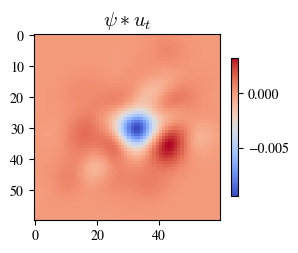

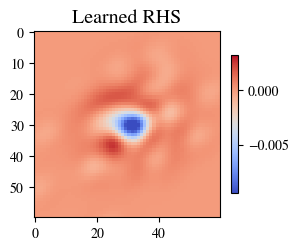

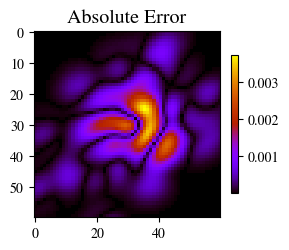

In [ ]:
# Weak form model
RHS = (model.library @ model.coeffs)
thyme = 4

plotz = {'cmap': 'coolwarm',
         'vmin': model.lhs.reshape(slicer)[:,:,thyme].min(),
         'vmax': model.lhs.reshape(slicer)[:,:,thyme].max()}

plt.figure(figsize=(3,3))
plt.imshow(model.lhs.reshape(slicer)[:,:,thyme], **plotz)
plt.title(f'$\psi * {model.lhs_name}$')
plt.colorbar(shrink=0.6)
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(RHS.reshape(slicer)[:,:,thyme], **plotz)
plt.title(f'Learned RHS')
plt.colorbar(shrink=0.6)
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(abs(model.lhs-RHS).reshape(slicer)[:,:,thyme], cmap='gnuplot')
plt.title(f'Absolute Error')
plt.colorbar(shrink=0.6)
plt.show()

Visualize potentials

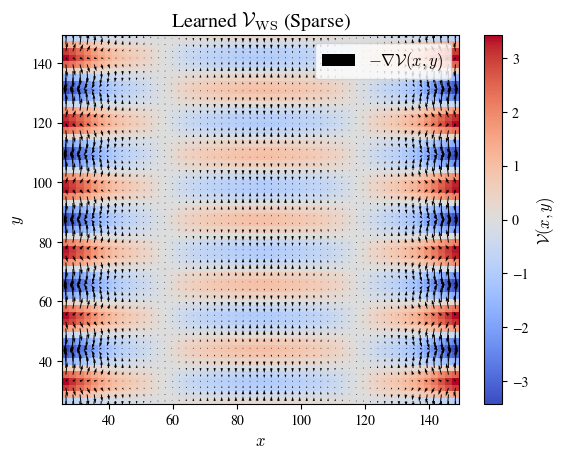

In [ ]:
# EXTERNAL POTENTIAL (SPARSE)
V_inds = [ind[0] for ind in w[6:-NK].nonzero().tolist()]
V_NMs = [NMs[ind] for ind in V_inds]
V_coeffs = [w[6:-NK][ind].item() for ind in V_inds]

# Construct V
V0 = np.zeros_like(X2)
V = V0 + np.add.reduce([V_coeffs[i]*V_nm(*V_NMs[i]) for i in range(len(V_coeffs))])
Vx = V0 + np.add.reduce([V_coeffs[i]*Vx_nm(*V_NMs[i]) for i in range(len(V_coeffs))])
Vy = V0 + np.add.reduce([V_coeffs[i]*Vy_nm(*V_NMs[i]) for i in range(len(V_coeffs))])

if V_inds != []:
  slicer = (slice(m[0],-m[0]),slice(m[1],-m[1]))
  plt.pcolormesh(X2[slicer], Y2[slicer], V[slicer], cmap='coolwarm',
                vmin=-abs(V[slicer]).max(), vmax=abs(V[slicer]).max())
  plt.colorbar(label='$\\mathcal{V}(x,y)$')
  plt.quiver(X2[slicer], Y2[slicer], -Vx[slicer], -Vy[slicer],
            color='k', label=r'$-\nabla\mathcal{V}(x,y)$')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title('Learned $\\mathcal{V}_{\\rm{WS}}$ (Sparse)')
  plt.legend(loc='upper right')
  plt.show()
else:
  print('Sparse V = 0')

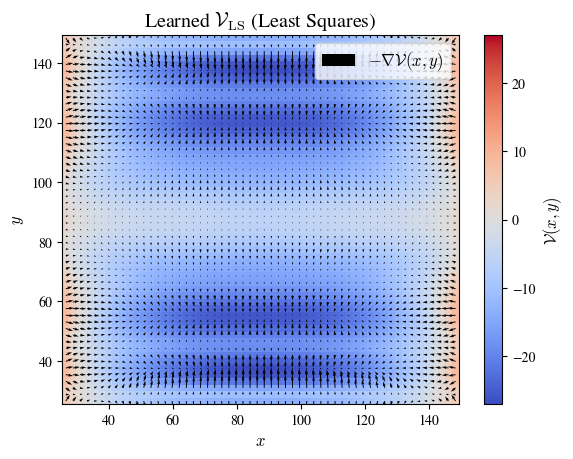

In [ ]:
# EXTERNAL POTENTIAL (LS)
#V_LS_coeffs = w_LS[6:-NK].tolist()
V_LS_coeffs = w_LS[4:-NK].tolist()
#V_LS_coeffs = w_LS[3:-NK].tolist()

# Construct V_LS
V_LS = V0 + np.add.reduce([V_LS_coeffs[i] * V_nm(*nm) for i,nm in enumerate(NMs)])
Vx_LS = V0 + np.add.reduce([V_LS_coeffs[i] * Vx_nm(*nm) for i,nm in enumerate(NMs)])
Vy_LS = V0 + np.add.reduce([V_LS_coeffs[i] * Vy_nm(*nm) for i,nm in enumerate(NMs)])

slicer = (slice(m[0],-m[0]), slice(m[1],-m[1]))
plt.pcolormesh(X2[slicer], Y2[slicer], V_LS[slicer], cmap='coolwarm',
               vmin=-abs(V_LS[slicer]).max(), vmax=abs(V_LS[slicer]).max())
#plt.pcolormesh(X2[slicer], Y2[slicer], np.sqrt(Vx_LS**2+Vy_LS**2)[slicer], cmap='coolwarm')
plt.colorbar(label='$\\mathcal{V}(x,y)$')
plt.quiver(X2[slicer], Y2[slicer], -Vx_LS[slicer], -Vy_LS[slicer],
           color='k', label=r'$-\nabla\mathcal{V}(x,y)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Learned $\\mathcal{V}_{\\rm{LS}}$ (Least Squares)')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Pick V constant
Vc = np.sqrt(Vx[slicer]**2 + Vy[slicer]**2).max().item()
Vc_LS = np.sqrt(Vx_LS[slicer]**2 + Vy_LS[slicer]**2).max().item()
print(f'Sparse: Vc = {Vc:.2f}')
print(f'Least squares: Vc = {Vc_LS:.2f}')

Sparse: Vc = 0.99
Least squares: Vc = 3.59


In [ ]:
# INTERACTION POTENTIAL (SPARSE)
K_inds = [ind[0] for ind in w[-NK:].nonzero().tolist()]
K_Ns = [ind for ind in K_inds]
K_coeffs = [w[-NK:][ind].item() for ind in K_inds]

# Construct K
K0 = np.zeros_like(XK)
K = K0 + np.add.reduce([K_coeffs[i] * K_n(K_Ns[i]) for i in range(len(K_coeffs))])
Kx = K0 + np.add.reduce([K_coeffs[i] * Kx_n(K_Ns[i]) for i in range(len(K_coeffs))])
Ky = K0 + np.add.reduce([K_coeffs[i] * Ky_n(K_Ns[i]) for i in range(len(K_coeffs))])

if K_inds != []:
  plt.pcolormesh(XK, YK, K, cmap='coolwarm', vmin=-abs(K[slicer]).max(), vmax=abs(K[slicer]).max())
  plt.colorbar(label='$\\mathcal{K}(r)$')
  #plt.quiver(XK, YK, -Kx, -Ky, color='k', label=r'$-\nabla\mathcal{K}(r)$')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.title('Learned $\\mathcal{K}_{\\rm{WS}}$ (Sparse)')
  plt.legend(loc='upper right')
  plt.show()
else:
  print('Sparse K = 0')

Sparse K = 0


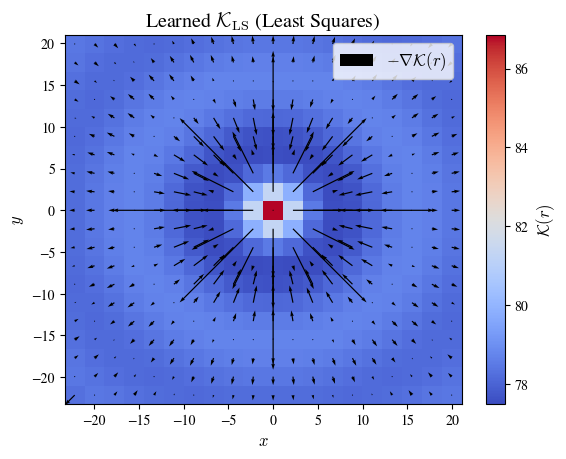

In [ ]:
# INTERACTION POTENTIAL (LS)
K_LS_coeffs = w_LS[-NK:].tolist()

# Construct K_LS
K_LS = K0 + np.add.reduce([K_LS_coeffs[n] * K_n(n) for n in range(len(K_LS_coeffs))])
Kx_LS = K0 + np.add.reduce([K_LS_coeffs[n] * Kx_n(n) for n in range(len(K_LS_coeffs))])
Ky_LS = K0 + np.add.reduce([K_LS_coeffs[n] * Ky_n(n) for n in range(len(K_LS_coeffs))])

#plt.pcolormesh(XK, YK, K_LS, cmap='coolwarm')
plt.pcolormesh(XK, YK, Uc*K_LS, cmap='coolwarm')
plt.colorbar(label='$\\mathcal{K}(r)$')
plt.quiver(XK, YK, -Kx_LS, -Ky_LS, color='k', label=r'$-\nabla\mathcal{K}(r)$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Learned $\\mathcal{K}_{\\rm{LS}}$ (Least Squares)')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Pick K constant
Kc = np.sqrt((Uc*Kx)**2 + (Uc*Ky)**2).max().item()
Kc_LS = np.sqrt((Uc*Kx_LS)**2 + (Uc*Ky_LS)**2).max().item()
print(f'Sparse: Kc = {Kc:.2f}')
print(f'Least squares: Kc = {Kc_LS:.2f}')

Sparse: Kc = 0.00
Least squares: Kc = 1.82


# Nonlinear in params

In [ ]:
from scipy.optimize import minimize
from scipy.signal import convolve as conv
from scipy.special import spherical_jn as jn

# Interaction potentials:
# Gaussian = Kc*exp(-r²/2σ²)
# Power law = Kc*(r/beta)^(-alpha)
# Bessel fcns = ∑ cn * jn(r/s)

class McKeanVlasovModel:
  def __init__(self, U, Ut, Ux, Uy, lapU, dx=1, dy=1, K_form="gaussian", V_terms=3):
    self.U = U
    self.Ut = Ut
    self.Ux, self.Uy = Ux, Uy
    self.lapU = lapU
    self.K_form = K_form
    self.V_terms = V_terms

    self.dx, self.dy = dx, dy
    self.nx, self.ny, self.nt = U.shape
    self.x = np.arange(0, self.nx) * dx
    self.y = np.arange(0, self.ny) * dy
    self.X, self.Y = np.meshgrid(self.x, self.y)
    self.KG = (slice(10,-10), slice(10,-10)) # K-grid
    #self.KG = (slice(15,-15), slice(15,-15))
    self.R = np.sqrt((self.X[self.KG]-self.nx/2*dx)**2 + (self.Y[self.KG]-self.ny/2*dy)**2)

  def V(self, V_params):
    result = np.zeros_like(self.X)
    for term in range(self.V_terms):
      [Vc, w1, w2, x0, y0] = V_params[5*term : 5*(term+1)]
      result += Vc * (np.cos(w1*(self.X - x0)) + np.cos(w2*(self.Y - y0)))
    return result

  def K(self, K_params):
    if self.K_form == "gaussian":
      [Kc, sigma] = K_params
      return Kc * np.exp(-self.R**2 / (2*sigma**2))

    elif self.K_form == "power_law":
      with np.errstate(divide='ignore'):
        Rinv = np.nan_to_num(1/self.R, posinf=0)
      [Kc, alpha, beta] = K_params
      return Kc * (beta*Rinv)**alpha

    elif self.K_form == "bessel":
      [scale, coeffs] = [K_params[0], K_params[1:]]
      result = np.zeros_like(self.R)
      for n, coeff in enumerate(coeffs):
        result += coeff * jn(n, self.R/scale)
      return result

    else:
      raise ValueError(f"Unknown potential: {self.K_form}")

  def grad_V(self, V_params):
    V_x = np.zeros_like(self.X)
    V_y = np.zeros_like(self.Y)
    for term in range(self.V_terms):
      [Vc, w1, w2, x0, y0] = V_params[5*term : 5*(term+1)]
      V_x += -Vc * w1 * np.sin(w1*(self.X - x0))
      V_y += -Vc * w2 * np.sin(w2*(self.Y - y0))
    return V_x, V_y

  def grad_K(self, K_params):
    with np.errstate(divide='ignore'):
      Rinv = np.nan_to_num(1/self.R, posinf=0)

    if self.K_form == "gaussian":
      [Kc, sigma] = K_params
      K_r = -(self.R/ sigma**2) * Kc*np.exp(-self.R**2 / (2*sigma**2))

    elif self.K_form == "power_law":
      [Kc, alpha, beta] = K_params
      K_r = -(alpha/beta) * Kc*(beta*Rinv)**(alpha+1)

    elif self.K_form == "bessel":
      [scale, coeffs] = [K_params[0], K_params[1:]]
      K_r = np.zeros_like(self.R)
      for n, coeff in enumerate(coeffs):
        K_r += coeff * jn(n, self.R/scale, derivative=True)/scale

    else:
      raise ValueError(f"Unknown potential: {self.K_form}")

    # Polar to Cartesian
    K_x = K_r * (self.X[self.KG] - self.nx/2*self.dx) * Rinv
    K_y = K_r * (self.Y[self.KG] - self.ny/2*self.dy) * Rinv
    return K_x, K_y

  def laplace_V(self, V_params):
    lap_V = np.zeros_like(self.X)
    for term in range(self.V_terms):
      Vc, w1, w2, x0, y0 = V_params[5*term : 5*(term+1)]
      V_xx = -(w1**2) * Vc * np.cos(w1*(self.X - x0))
      V_yy = -(w2**2) * Vc * np.cos(w2*(self.Y - y0))
      lap_V += V_xx + V_yy
    return lap_V

  def laplace_K(self, K_params):
    if self.K_form == "gaussian":
      [Kc, sigma] = K_params
      [R2, s2] = [self.R**2, sigma**2]
      return (R2/s2**2 - 2/s2**2) * Kc * np.exp(-R2/(2*s2))

    elif self.K_form == "power_law":
      with np.errstate(divide='ignore'):
        Rinv = np.nan_to_num(1/self.R, posinf=0)
      [Kc, alpha, beta] = K_params
      return -(alpha/beta)**2 * Kc * (beta*Rinv)**(alpha+2)

    elif self.K_form == "bessel":
      [scale, coeffs] = [K_params[0], K_params[1:]]
      with np.errstate(divide='ignore'):
        Rs = self.R/scale
        Rs_inv = np.nan_to_num(1/Rs, posinf=0)
      [K_r, K_rr] = [np.zeros_like(Rs), np.zeros_like(Rs)]

      for n, coeff in enumerate(coeffs):
        K_r += (coeff/scale) * jn(n, Rs, derivative=True)
        K_rr1 = coeff * (Rs_inv**2) * (n**2 - n - Rs**2) * jn(n, Rs)
        K_rr2 = coeff * (Rs_inv**2) * (2*Rs) * jn(n+1, Rs)
      return K_rr + Rs_inv*K_r

    else:
      raise ValueError(f"Unknown potential: {self.K_form}")

  def compute_rhs(self, params):
    V_params = params[0 : 5*self.V_terms]
    K_params = params[5*self.V_terms : -1]
    D = params[-1]
    axes = (slice(None), slice(None), None)

    # External potential, ∇·(u∇V)
    [V_x, V_y] = self.grad_V(V_params)
    lap_V = self.laplace_V(V_params)
    div_u_gradV = self.Ux*V_x[axes] + self.Uy*V_y[axes] + self.U*lap_V[axes]

    # Interaction potential, ∇·(u(∇K*u))
    [K_x, K_y] = self.grad_K(K_params)
    lap_K = self.laplace_K(K_params)
    div1 = self.Ux * conv(self.U, K_x[axes], mode='same')
    div2 = self.Uy * conv(self.U, K_y[axes], mode='same')
    div3 = self.U * conv(self.U, lap_K[axes], mode='same')
    div_u_gradK = (self.dx * self.dy)*(div1 + div2 + div3)
    return div_u_gradV + div_u_gradK + D*self.lapU

  def compute_pde_loss(self, params):
    rhs = self.compute_rhs(params)
    residual = self.Ut - rhs
    return np.mean(residual**2)
    # b = self.Ut.copy().reshape(-1)
    # r = (self.Ut - rhs).reshape(-1)
    # FVU = (r @ r) / ((b-b.mean()) @ (b-b.mean()))
    # return FVU**2

  def fit_pde(self, initial_params=None, bounds=None):
    # Default initial parameters
    D0 = [5.0]

    if initial_params is None:
      freq = 2*np.pi/175
      V_params = [] # [Vc, w1, w2, x0, y0]
      for n in range(self.V_terms):
        V_n = [1/(n+1)**2, freq*(9+n), freq*(5+n), 0, 0]
        V_params.extend(V_n)

      if self.K_form == "gaussian":
        K_params = [0.1, 5] # [Kc, sigma]
      elif self.K_form == "power_law":
        K_params = [0.1, 1, 1] # [Kc, alpha, beta]
      elif self.K_form == "bessel":
        N_bessel = 4
        #N_bessel = 3
        K_params = [8] + N_bessel*[0.01] # Default scale + n terms
      initial_params = V_params + K_params + D0

    # Default parameter bounds
    if bounds is None:
      bounds = [(None, None) for _ in range(len(initial_params))]
      bounds[-1] = (0, None) # 0 < D

      for term in range(self.V_terms):
        bounds[5*term + 1] = (0, 1) # 0 < w1 < 1
        bounds[5*term + 2] = (0, 1) # 0 < w2 < 1
        bounds[5*term + 3] = (-np.pi, np.pi) # -pi < x0 < pi
        bounds[5*term + 4] = (-np.pi, np.pi) # -pi < y0 < pi
      V_params_count = 5 * self.V_terms

      if self.K_form == "gaussian":
        bounds[V_params_count + 1] = (0, None) # sigma
      elif self.K_form == "power_law":
        bounds[V_params_count + 1] = (0, None) # alpha
        bounds[V_params_count + 2] = (0, None) # beta
      elif self.K_form == "bessel":
        bounds[V_params_count] = (1, 10) # 1 < scale < 10

    # Run optimization
    print(f"Starting optimization with {self.K_form} potential...")
    options = {'maxiter': 500}

    with tqdm(total=options.get('maxiter'), desc="Progress") as pbar:
      def callback(x):
        pbar.update(1)

      result = minimize(
        self.compute_pde_loss,
        initial_params,
        #method = 'L-BFGS-B',
        method = 'Nelder-Mead',
        bounds = bounds,
        #tol = 1e-11,
        tol = 1e-32,
        options = options,
        callback = callback)

    print(f"Optimization complete: {result.nit} iterations")
    print(f"Final MSE: {result.fun:.5e}\n")
    self.print_params(result.x)
    return result

  def print_params(self, params):
    print("External potential:")
    print("V(x,y) = ", end="")
    for term in range(self.V_terms):
      [Vc, w1, w2, x0, y0] = params[5*term : 5*(term+1)]
      if term > 0:
        print(" + \n")
      print(f"({Vc:.2e}) * [cos({w1:.2f}(x-{x0:.2f})) + cos({w2:.2f}(y-{y0:.2f}))]\n")
    V_params_count = 5 * self.V_terms

    print("Interaction potential:")
    if self.K_form == "gaussian":
      [Kc, sigma] = params[V_params_count:-1]
      print(f"K(r) = ({Kc:.2e}) * exp(-r²/(2*{sigma:.2f}²))\n")

    elif self.K_form == "power_law":
      [Kc, alpha, beta] = params[V_params_count:-1]
      print(f"K(r) = ({Kc:.2e}) * (r/{beta:.2f})^(-{alpha:.2f})\n")

    elif self.K_form == "bessel":
      scale = params[V_params_count]
      coeffs = params[V_params_count+1:-1]
      bessy = []
      for n, coeff in enumerate(coeffs):
        bessy.append(f"({coeff:.2e}) * j_{n}(r/{scale:.2f})")
      bessy = " + ".join(bessy)
      print(f"K(r) = {bessy}\n")

    print("Diffusion constant:")
    print(f"D = {params[-1]:.2f}")

In [ ]:
# from scipy.signal import savgol_filter as SG

# # Nump-ify
# x = np.array(x)
# y = np.array(y)
# dx = np.array(dx)
# dy = np.array(dy)
# #X,Y,T = np.meshgrid(x,y,tau)

# #Unp = np.array(U)
# #Unp = np.array(U1)
# Unp = np.array(U_interp)

# # SG filter for derivatives
# [window, poly] = [7, 3]
# #Ut = SG(Unp, window-2, poly, deriv=1, delta=dtau, axis=2) * dtau_scales
# Ut = SG(Unp, window-2, poly, deriv=1, delta=t_new.diff()[0].item(), axis=2)
# Ux = SG(Unp, window, poly, deriv=1, delta=dx, axis=0, mode='constant')
# Uy = SG(Unp, window, poly, deriv=1, delta=dy, axis=1, mode='constant')
# Uxx = SG(Unp, window, poly, deriv=2, delta=dx, axis=0, mode='constant')
# Uyy = SG(Unp, window, poly, deriv=2, delta=dy, axis=1, mode='constant')
# lapU = Uxx + Uyy

# Nump-ify
x = np.array(x)
y = np.array(y)
dx = np.array(dx)
dy = np.array(dy)
X,Y,T = np.meshgrid(x,y,t_new)

Unp = np.array(U_interp)

# Derivatives
Ut = (np.roll(Unp,-1,axis=2) - np.roll(Unp,1,axis=2)) / (2*dt)

Ux = (np.roll(Unp,-1,axis=0) - np.roll(Unp,1,axis=0)) / (2*dx)
Uy = (np.roll(Unp,-1,axis=1) - np.roll(Unp,1,axis=1)) / (2*dy)

Uxx = (np.roll(Unp,-1,axis=0) - 2*Unp + np.roll(Unp,1,axis=0)) / (2*dx)
Uyy = (np.roll(Unp,-1,axis=1) - 2*Unp + np.roll(Unp,1,axis=1)) / (2*dy)
lapU = Uxx + Uyy

In [ ]:
# thyme = 5

# plt.imshow(Ut[:,:,thyme], cmap='coolwarm')
# plt.colorbar()
# plt.show()

# plt.imshow(lapU[:,:,thyme], cmap='coolwarm')
# plt.colorbar()
# plt.show()

In [ ]:
# Interaction potentials:
# gaussian = A*exp(-r²/2σ²)
# power_law = A*(r/beta)^(-alpha)
# Bessel fcns = ∑ cn * jn(r/s)

#options = {'dx':dx, 'dy':dy, 'K_form':"gaussian", 'V_terms':1}
options = {'dx':dx, 'dy':dy, 'K_form':"bessel", 'V_terms':1}
#options = {'dx':dx, 'dy':dy, 'K_form':"bessel", 'V_terms':4}

model = McKeanVlasovModel(Unp, Ut, Ux, Uy, lapU, **options)
results = model.fit_pde()

params = results.x
V_params = params[0 : 5*model.V_terms]
K_params = params[5*model.V_terms : -1]
D = params[-1]

Starting optimization with bessel potential...


Progress: 100%|█████████▉| 499/500 [01:04<00:00,  7.76it/s]

Optimization complete: 500 iterations
Final MSE: 0.00000

External potential:
V(x,y) = (6.33e+00) * [cos(0.05(x--0.43)) + cos(0.08(y-0.04))]

Interaction potential:
K(r) = (-2.23e+00) * j_0(r/9.07) + (-1.19e+00) * j_1(r/9.07) + (2.49e+00) * j_2(r/9.07) + (7.34e-02) * j_3(r/9.07)

Diffusion constant:
D = 0.04


In [ ]:
# Point-by-point equation residuals
rhs = model.compute_rhs(params)
r = (model.Ut - rhs).reshape(-1)
Ut_inf = abs(model.Ut).max().item()

b = model.Ut.reshape(-1)
R2 = 1 - (r@r)/((b-b.mean())@(b-b.mean()))
print(f'R^2: {R2:.3f}')

Linf = abs(r).max() / Ut_inf
print(f'Relative L∞ error: {Linf:.3f}')

L2 = np.linalg.norm(r) / np.linalg.norm(model.Ut.reshape(-1))
print(f'Relative L2 error: {L2:.3f}')

R^2: 0.011
Relative L∞ error: 1.001
Relative L2 error: 0.994


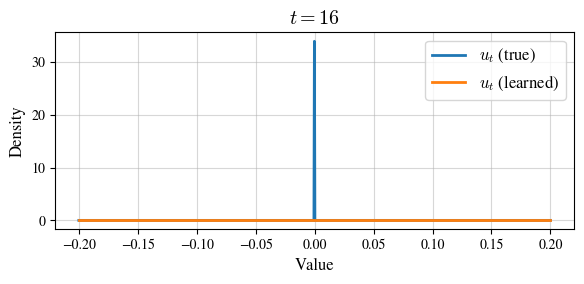

In [ ]:
from scipy.stats import gaussian_kde

# Error statistics
thyme = 5
true_vals = model.Ut[:, :, thyme].reshape(-1)
learned_vals = rhs[:, :, thyme].reshape(-1)

# KDEs
true_kde = gaussian_kde(true_vals)
learned_kde = gaussian_kde(learned_vals)

# Evaluation grid
x_eval = np.linspace(-0.2, 0.2, 1000)

# Plot
plt.figure(figsize=(6, 3))
plt.grid(True, alpha=0.5)
plt.plot(x_eval, true_kde(x_eval), label='$u_t$ (true)', lw=2)
plt.plot(x_eval, learned_kde(x_eval), label='$u_t$ (learned)', lw=2)
plt.xlabel(r'Value')
plt.ylabel('Density')
plt.title(f'$t={t[thyme]}$')
#plt.yscale('log')
plt.legend()
#plt.xlim([-0.1, 0.1])
plt.tight_layout()
plt.show()

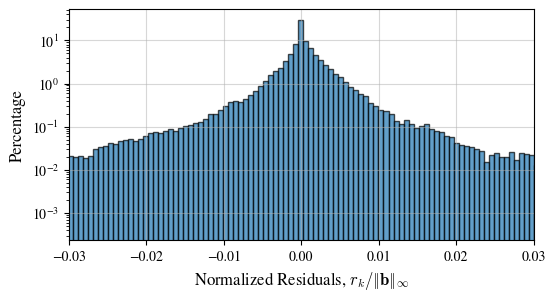

In [ ]:
# Plot equation residuals
weights = 100*np.ones_like(r)/len(r)

plt.figure(figsize=(6,3))
plt.grid(True, alpha=0.5)
plt.hist(r/Ut_inf, bins=1500, edgecolor='k', alpha=0.7, weights=weights)
plt.xlabel(r'Normalized Residuals, $r_k/|\!|\mathbf{b}|\!|_{\infty}$')
plt.ylabel('Percentage')
plt.xlim([-0.03, 0.03])
plt.yscale('log')
plt.show()

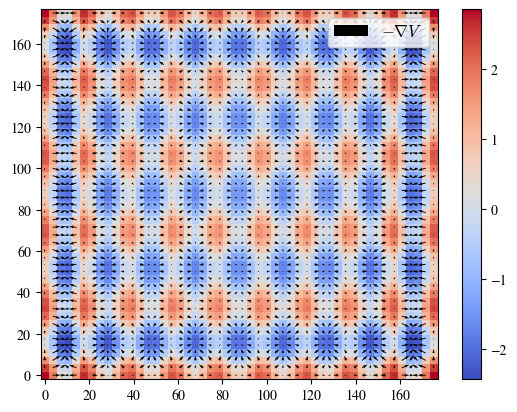

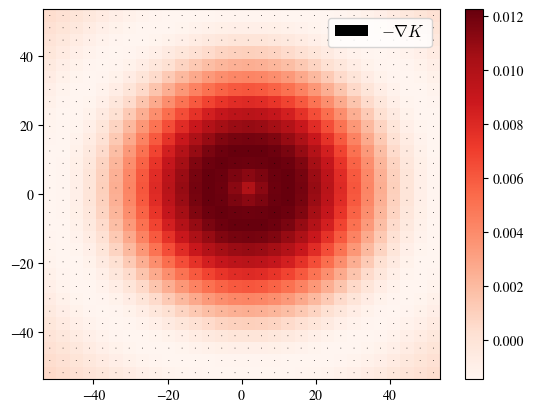

In [ ]:
# External potential
plt.pcolormesh(model.X, model.Y, model.V(V_params), cmap='coolwarm')
plt.colorbar()

V_x, V_y = model.grad_V(V_params)
plt.quiver(model.X, model.Y, -V_x, -V_y, color='k', label=r'$-\nabla{V}$')
plt.legend(loc='upper right')
plt.show()

lap_V = model.laplace_V(V_params)
# plt.imshow(lap_V, cmap='coolwarm')
# plt.colorbar()
# plt.show()

# Interaction potential
[Xm, Ym] = [model.X[model.KG]-model.X.mean(), model.Y[model.KG]-model.Y.mean()]
plt.pcolormesh(Xm, Ym, model.K(K_params), cmap='Reds')
plt.colorbar()

K_x, K_y = model.grad_K(K_params)
plt.quiver(Xm, Ym, -K_x, -K_y, color='k', scale=0.5, label=r'$-\nabla{K}$')
plt.legend(loc='upper right')
plt.show()

lap_K = model.laplace_K(K_params)
# plt.imshow(lap_K, cmap='Reds')
# plt.colorbar()
# plt.show()

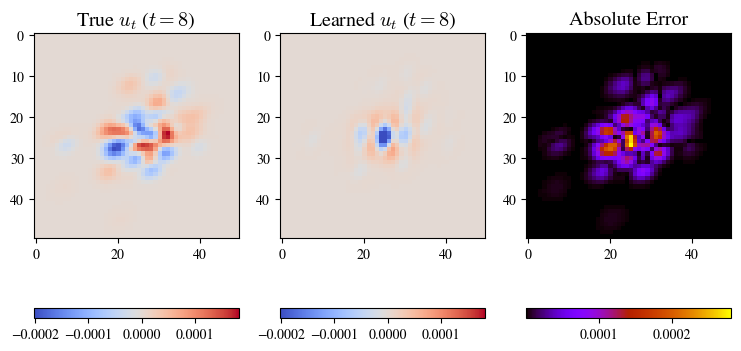

In [ ]:
# Pointwise error
thyme = 4

fig,ax = plt.subplots(1,3, figsize=(9,6))

pcm = ax[0].imshow(Ut[:,:,thyme], cmap='coolwarm')
plt.colorbar(pcm, orientation='horizontal')
ax[0].set_title(f'True $u_t$ ($t={t[thyme]}$)')

vmin = Ut[:,:,thyme].min()
vmax = Ut[:,:,thyme].max()
pcm = ax[1].imshow(rhs[:,:,thyme], cmap='coolwarm', vmin=vmin, vmax=vmax)
plt.colorbar(pcm, orientation='horizontal')
ax[1].set_title(f'Learned $u_t$ ($t={t[thyme]}$)')

pcm = ax[2].imshow(abs(model.Ut - rhs)[:,:,thyme], cmap='gnuplot')
plt.colorbar(pcm, orientation='horizontal')
ax[2].set_title(f'Absolute Error')

plt.show()

In [ ]:
# model = McKeanVlasovModel(Unp, Ut, Ux, Uy, lapU, dx=dx, dy=dy, K_form="gaussian")

# n_trials = 10
# all_results = []

# for i in range(n_trials):
#     print(f"\n--- Trial {i+1} ---")

#     # Generate random initial parameters
#     freq = 2*np.pi/175
#     Vc = np.random.uniform(0.1, 2.0)
#     w1 = np.random.uniform(0.01, 1.0)
#     w2 = np.random.uniform(0.01, 1.0)
#     x0 = np.random.uniform(-np.pi, np.pi)
#     y0 = np.random.uniform(-np.pi, np.pi)

#     if model.K_form == "gaussian":
#         Kc = np.random.uniform(0.01, 1.0)
#         sigma = np.random.uniform(0.1, 10.0)
#         K_params = [Kc, sigma]
#     elif model.K_form == "power_law":
#         Kc = np.random.uniform(0.01, 1.0)
#         alpha = np.random.uniform(0.1, 3.0)
#         beta = np.random.uniform(0.1, 5.0)
#         K_params = [Kc, alpha, beta]

#     D = np.random.uniform(0.01, 10.0)

#     # Combine all into initial parameter list
#     initial_params = [Vc, w1, w2, x0, y0] + K_params + [D]

#     # Fit model with these initial parameters
#     result = model.fit_pde(initial_params=initial_params)
#     all_results.append(result)

#     # Plotting the fit for this trial
#     rhs_pred = model.compute_rhs(result.x)
#     t_index = model.nt // 2  # Middle time slice

#     fig, axes = plt.subplots(1, 3, figsize=(15, 4))
#     im1 = axes[0].imshow(rhs_pred[:, :, t_index], origin='lower')
#     axes[0].set_title("Predicted RHS")
#     plt.colorbar(im1, ax=axes[0])

#     im2 = axes[1].imshow(model.Ut[:, :, t_index], origin='lower')
#     axes[1].set_title("Observed Ut")
#     plt.colorbar(im2, ax=axes[1])

#     im3 = axes[2].imshow(model.Ut[:, :, t_index] - rhs_pred[:, :, t_index], origin='lower')
#     axes[2].set_title("Residual (Ut - RHS)")
#     plt.colorbar(im3, ax=axes[2])

#     plt.suptitle(f"Trial {i+1} - MSE: {result.fun:.3e}")
#     plt.tight_layout()
#     plt.show()

# # Optionally: sort and print top N results by final loss
# sorted_results = sorted(all_results, key=lambda r: r.fun)
# print("\n=== Top Results ===")
# for i, res in enumerate(sorted_results[:3]):
#     print(f"\nResult {i+1}: MSE = {res.fun:.5e}")
#     model.print_params(res.x)

In [ ]:
# import sympy as sp

# # Coordinates
# x, y, t = sp.symbols('x y t', real=True)
# xp, yp = sp.symbols('xp yp', real=True)

# # Parameters
# theta1, theta2, theta3 = sp.symbols('theta1 theta2 theta3', positive=True, real=True)
# theta = [theta1, theta2, theta3]
# N = sp.Symbol('N', positive=True, real=True)

# # Distance for convolution
# r2 = (x - xp)**2 + (y - yp)**2
# r = sp.sqrt(r2)

# # Gaussian kernel K(r; theta3)
# K = (1 / (4 * sp.pi * theta3)) * sp.exp(-r2 / (4 * theta3))
# dK_dr = sp.diff(K, r)

# # Chain rule: ∇K = dK/dr * ∇r = dK/dr * (x - xp, y - yp) / r
# gradK_x = sp.simplify(dK_dr * (x - xp) / r)
# gradK_y = sp.simplify(dK_dr * (y - yp) / r)

# # u(x, y, t) and u(x', y', t)
# u = sp.Function('u')(x, y, t)
# up = sp.Function('u')(xp, yp, t)
# ut = sp.Derivative(u, t)

# # V(x, y; θ)
# V = theta1 * x**2 + theta2 * y**2
# gradV = [sp.diff(V, x), sp.diff(V, y)]
# div_u_gradV = sp.diff(u * gradV[0], x) + sp.diff(u * gradV[1], y)

# # Convolution integrals
# conv_x = sp.integrate(gradK_x * up, (xp, -sp.oo, sp.oo), (yp, -sp.oo, sp.oo))
# conv_y = sp.integrate(gradK_y * up, (xp, -sp.oo, sp.oo), (yp, -sp.oo, sp.oo))

# # ∇⋅(u (∇K * u))
# div_u_conv = sp.diff(u * conv_x, x) + sp.diff(u * conv_y, y)

# # D(θ) and Laplacian of u
# D = theta3
# lap_u = sp.diff(u, x, x) + sp.diff(u, y, y)

# # Residual and loss
# residual = ut + div_u_gradV + div_u_conv - D * lap_u
# L = (1/N) * residual**2

# # Gradient of L wrt θ
# grad_L = [sp.simplify(sp.diff(L, th)) for th in theta]

# # Output symbolic gradient
# for i, dL in enumerate(grad_L):
#     print(f"dL/dtheta_{i+1} =")
#     sp.pprint(dL)
#     print()